# Importing KabaddiPy

This exemplar notebook demonstrates the full functionality of the module, including all codes from the paper, to ensure full reproducibility.

--------------------------------
14. Testing plot_player_zones_grid---------------------------------


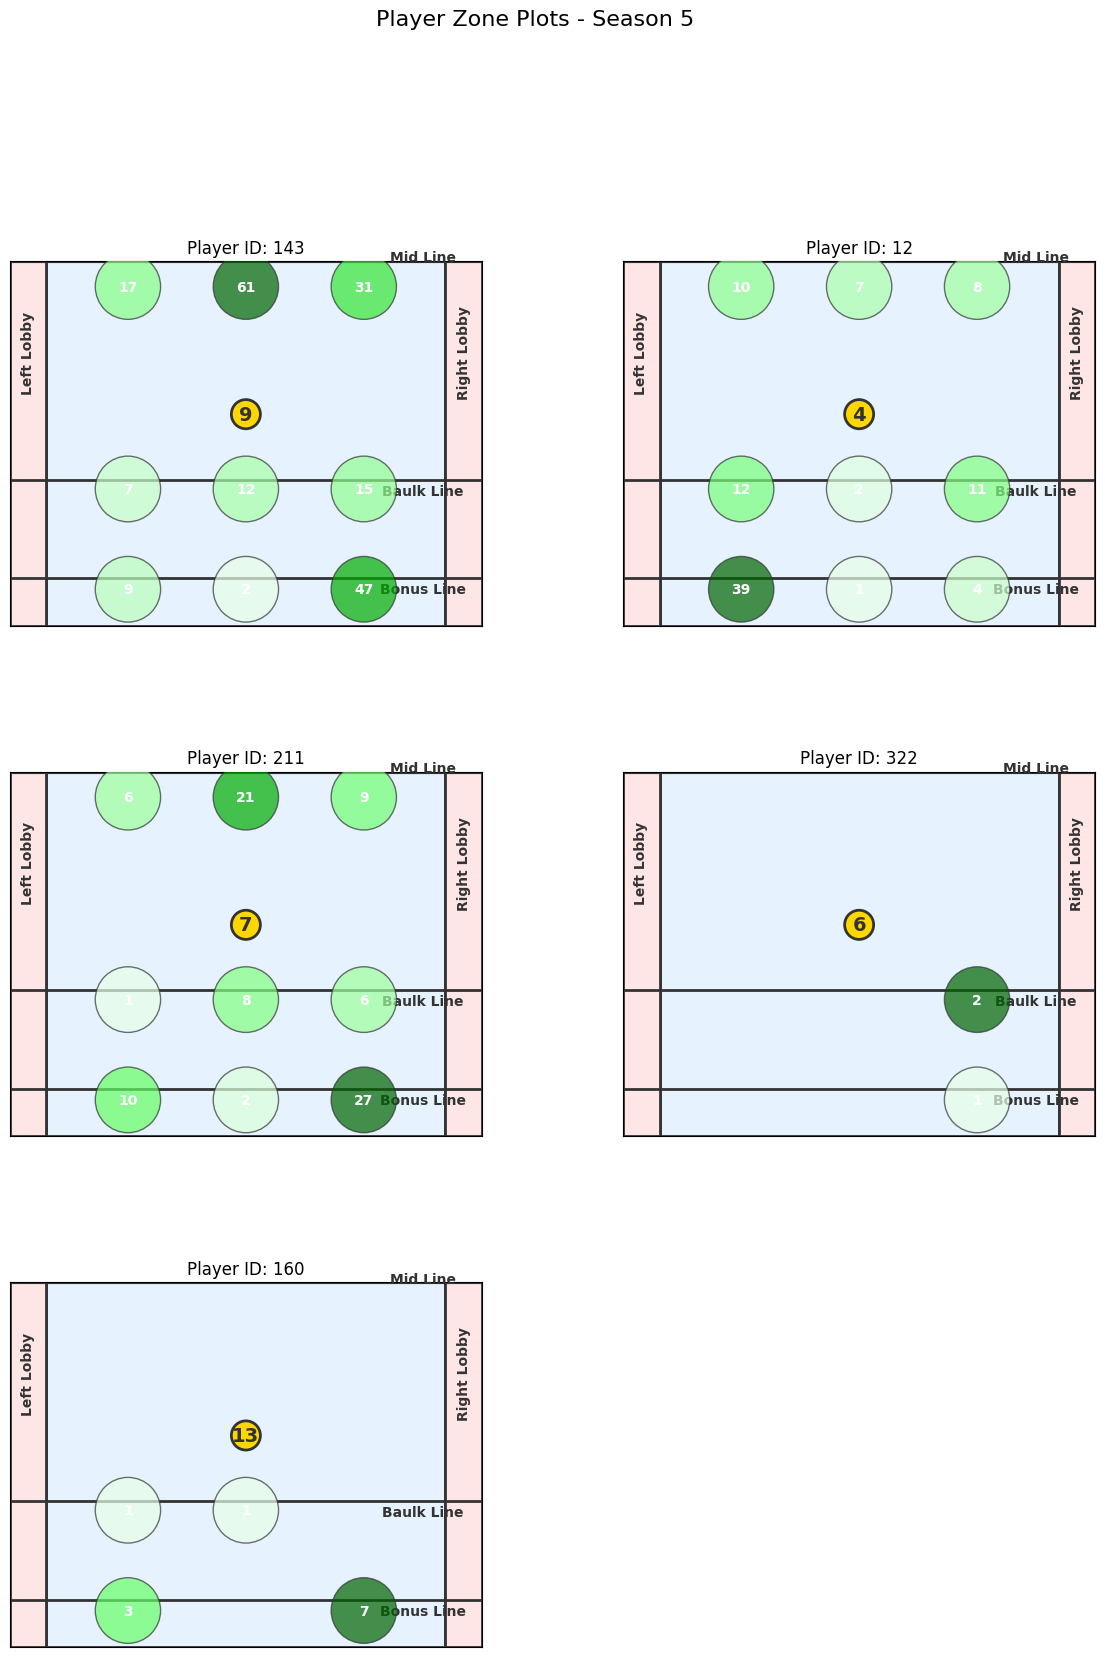

In [3]:
import warnings
import json
import os
from pathlib import Path
from typing import List, Tuple, Dict, Any

import numpy as np
import pandas as pd
import json
import pandas as pd

import json
import pandas as pd
import glob
import re

from pandas import DataFrame
from matplotlib import gridspec

import math
import json

from jinja2.filters import do_int
from matplotlib.patches import Rectangle, Circle, Wedge
from matplotlib.colors import LinearSegmentedColormap
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from setuptools.command.rotate import rotate
from matplotlib.lines import Line2D


class KabaddiDataAPI:
    def __init__(self):
        self.base_path = "./MatchData_pbp"
    # for a season - display the standings

    def get_pkl_standings(self, season=None, qualified=False, team_id=None):
        """
        Retrieve the Pro Kabaddi League (PKL) standings for a specified season.

        Parameters:
        -----------
        season : int, optional
            The season number for which to retrieve standings. Defaults to 10 if not specified.
        qualified : bool, optional
            If True, returns an additional DataFrame with only qualified teams. Defaults to False.
        team_id : int, optional
            If specified, returns standings for only this team. Defaults to None (all teams).

        Returns:
        --------
        pandas.DataFrame or tuple of pandas.DataFrame
            If qualified is False:
                Returns a DataFrame containing standings for all teams.
            If qualified is True:
                Returns a tuple of two DataFrames:
                (qualified_teams_standings, all_teams_standings)

        The DataFrame(s) include the following columns:
        - Group: The group name (if applicable)
        - Season: The season number
        - Team_Id: Unique identifier for the team
        - Team_Name: Name of the team
        - League_position: Current position in the league
        - Matches_played: Number of matches played
        - Wins, Lost, Tied, Draws: Match outcomes
        - No Result: Number of matches with no result
        - League_points: Total points in the league
        - Score_diff: Score difference
        - Qualified: Boolean indicating if the team qualified

        Raises:
        -------
        FileNotFoundError: If the standings file for the specified season is not found.
        JSONDecodeError: If there's an issue parsing the JSON file.

        Note:
        -----
        If the standings data for the specified season is empty, an empty DataFrame is returned.
        """
    # ... (rest of the function implementation remains the same)
        
        if season is None:
            season = 10

        file_path = Path(f"./PKL_Standings/pkl_standings_s{season}.json")

        with open(file_path, 'r') as f:
            data = json.load(f)

        standings = data['standings']
        team_standings_info_list, qualified_teams_standings_info_list = [], []

        if len(standings['groups']) == 0:
            return pd.DataFrame()

        def process_team(group_name, team):
            team_info = {
                'Group': group_name,
                'Season': season,
                'Team_Id': team['team_id'],
                'Team_Name': team['team_name'],
                'League_position': team['position'],
                'Matches_played': team['played'],
                'Wins': team['wins'],
                'Lost': team['lost'],
                'Tied': team['tied'],
                'Draws': team['draws'],
                'No Result': team['noresult'],
                'League_points': team['points'],
                'Score_diff': team['score_diff'],
                'Qualified': team['is_qualified'],
            }

            if (team_id is None or int(team['team_id']) == team_id):
                team_standings_info_list.append(team_info)
                if qualified and team['is_qualified']:
                    qualified_teams_standings_info_list.append(team_info)

        for group in standings['groups']:
            if 'name' in group and group['name'] != "":
                group_name = group['name']
            else:
                group_name = 'Main'
            for team in group['teams']['team']:
                process_team(group_name, team)

        team_info_df = pd.DataFrame(team_standings_info_list)

        if qualified:
            qualified_teams_df = pd.DataFrame(qualified_teams_standings_info_list)
            return qualified_teams_df, team_info_df

        return team_info_df


    def get_season_matches(self, season="all"):
        """
        Retrieve match data for a specific season or all seasons.

        This function loads match data from JSON files and returns it as a pandas DataFrame.

        Parameters:
        -----------
        season : str or int, optional
            The season number for which to retrieve match data. 
            Use "all" to retrieve data for all seasons (default).
            If a specific season is desired, provide the season number as a string or integer.

        Returns:
        --------
        pandas.DataFrame
            A DataFrame containing match details with the following columns:
            - Season: The season number
            - Match_ID: Unique identifier for the match
            - Match_Name: Name of the match event
            - League_Stage: Stage of the league (e.g., group stage, playoffs)
            - Year: Year of the match
            - Venue: Location where the match was played
            - Match_Outcome: Outcome of the match
            - Start_Date: Start date and time of the match
            - End_Date: End date and time of the match
            - Result: Result code of the match
            - Winning Margin: Margin of victory
            - team_score_1: Score of the first team
            - team_score_2: Score of the second team
            - team_name_1: Name of the first team
            - team_id_1: ID of the first team
            - team_name_2: Name of the second team
            - team_id_2: ID of the second team

        Notes:
        ------
        - The function reads data from JSON files located in the './Matches-Overview/' directory.
        - For "all" seasons, it sorts the files based on the season number extracted from the filename.
        - Each row in the returned DataFrame represents a single match.
        """
        
        matches_list = []

        # Determine the file(s) to load based on the season input
        if season == "all":
            files = glob.glob('./Matches-Overview/S*_PKL_MatchData.json')
            # Sort the files based on the season number
            files = sorted(files, key=lambda x: int(re.search(r'S(\d+)', x).group(1)))
            print(files)

        else:
            files = [f'./Matches-Overview/S{season}_PKL_MatchData.json']

        for file in files:
            
            with open(file) as f:
                data = json.load(f)


            for match in data['matches']:

                team_name, team_id, team_score = [], [], []

                for p in match['participants']:
                    # print(p['name'])
                    team_name.append(p['name'])
                    team_id.append(p['id'])
                    team_score.append(p['value'])


                match_details = {
                    "Season": match['tour_name'].split(",")[0].split(" ")[-1],
                    'Match_ID': match['game_id'],
                    "Match_Name": match['event_name'],
                    "League_Stage": match['event_stage'],
                    "Year": match['tour_name'].split(",")[1].strip(),
                    "Venue": match['venue_name'].lower().title().strip(),
                    'Match_Outcome': match['event_sub_status'],
                    "Start_Date": match['start_date'],
                    "End_Date": match['end_date'],
                    "Result": match['result_code'],
                    "Winning Margin": match['winning_margin'],
                    'team_score_1': team_score[0],
                    'team_score_2': team_score[1],
                    'team_name_1': team_name[0],
                    'team_id_1': team_id[0],
                    'team_name_2': team_name[1],
                    'team_id_2': team_id[1],
                }

                

                matches_list.append(match_details)

        # Convert the list of dictionaries into a DataFrame
        df = pd.DataFrame(matches_list)

        # df.to_csv("matches_data.csv")

        # Display the DataFrame
        return df


    def get_team_info(self, team_id=None, season='overall'):
        """
        Retrieve team information for a specific team and season.

        This function fetches aggregated statistics, raider skills, and defender skills
        for a given team in a specified season or across all seasons.

        Parameters:
        -----------
        team_id : int
            The unique identifier for the team.
        season : str or int, optional
            The season for which to retrieve data. Can be:
            - 'overall' (default): Retrieves data across all seasons.
            - int: A specific season number.

        Returns:
        --------
        tuple
            A tuple containing five elements:
            1. df_rank (DataFrame): Team rankings in various categories.
            2. df_value (DataFrame): Raw statistic values for the team.
            3. df_per_match (DataFrame): Per-match statistics for the team.
            4. filtered_team_raider_skills (DataFrame or None): Raider skills data for the team.
            5. filtered_team_defender_skills (DataFrame or None): Defender skills data for the team.

        Notes:
        ------
        - If season is 'overall', raider and defender skills data are not returned (set to None).
        - For a specific season, all DataFrames are transposed for easier reading.
        - If no data is found for the specified team and season, all return values will be None.

        Raises:
        -------
        ValueError: If the input types are incorrect or if the season is invalid.
        """
        if season != 'overall':
            season = int(season)
        
        df_team_aggregated_stats = pd.read_csv("./Team-Wise-Data/PKL_AggregatedTeamStats.csv")
        df_team_raider_skills = pd.read_csv("./Team-Wise-Data/ALL_Raider_Skills_Merged.csv")
        df_team_defender_skills = pd.read_csv("./Team-Wise-Data/ALL_Defensive_Skills_Merged.csv")
        
        if team_id:
            team_id = int(team_id)
        else:
            team_id=None

        def find_team_column(dataframe, team_id):
            for col in dataframe.columns:
                if f"({team_id})" in col:
                    return col
            return None
        
        if team_id:
            team_column_team_raider_skills = find_team_column(df_team_raider_skills, team_id)
            team_column_team_defender_skills = find_team_column(df_team_defender_skills, team_id)
        else:
            team_column_team_raider_skills = -1
            team_column_team_defender_skills = -1
        
        

        if season == 'overall':
            
            if team_id:
                filtered_team_aggregated_stats = df_team_aggregated_stats[df_team_aggregated_stats['team_id'] == team_id]
            
            rows_overall = filtered_team_aggregated_stats[filtered_team_aggregated_stats['season'] == 'all']
            other_rows = filtered_team_aggregated_stats[filtered_team_aggregated_stats['season'] != 'all']

            filtered_team_aggregated_stats = pd.concat([rows_overall, other_rows]).reset_index(drop=True)
            filtered_team_raider_skills = None
            filtered_team_defender_skills = None

        
        else:

            df_team_aggregated_stats['team_id'] = pd.to_numeric(df_team_aggregated_stats['team_id'], errors='coerce')
            df_team_aggregated_stats['season'] = pd.to_numeric(df_team_aggregated_stats['season'], errors='coerce')
            
            filtered_team_aggregated_stats = df_team_aggregated_stats[df_team_aggregated_stats['season'] == season]
            
            if team_id:
                filtered_team_aggregated_stats = filtered_team_aggregated_stats[filtered_team_aggregated_stats['team_id'] == team_id]

            if team_column_team_raider_skills:            
                filtered_team_raider_skills = df_team_raider_skills[df_team_raider_skills['Season'] == season]
                
                if team_column_team_raider_skills == -1:
                    cols = filtered_team_raider_skills.columns.tolist()
                    filtered_team_raider_skills = filtered_team_raider_skills[[cols]].reset_index(drop=True)

                else:
                    filtered_team_raider_skills = filtered_team_raider_skills[['Season','Skill Type','Skill Name',team_column_team_raider_skills]].reset_index(drop=True)
            else:
                filtered_team_raider_skills = None


            if team_column_team_defender_skills:
                filtered_team_defender_skills = df_team_defender_skills[df_team_defender_skills['Season'] == season]
                
                if team_column_team_raider_skills == -1:
                    cols = filtered_team_defender_skills.columns.tolist()
                    filtered_team_defender_skills = filtered_team_defender_skills[[cols]].reset_index(drop=True)

                else:
                    filtered_team_defender_skills = filtered_team_defender_skills[['Season','Skill Type','Skill Name',team_column_team_raider_skills]].reset_index(drop=True)

            else:
                filtered_team_defender_skills = None

        if filtered_team_aggregated_stats.empty:
            print(f"No data found in CSV for team_id {team_id} in season {season}")
            return None, None, None, None, None
        

        rank_columns = [col for col in filtered_team_aggregated_stats.columns if col.endswith('_rank')]
        value_columns = [col for col in filtered_team_aggregated_stats.columns if col.endswith('_value')]
        per_match_columns = [col for col in filtered_team_aggregated_stats.columns if col.endswith('_per-match')]

        # print(f"len rank cols: {len(rank_columns)}")
        # print(f"len value cols: {len(value_columns)}")
        # print(f"len per match cols: {len(per_match_columns)}")

        df_rank = filtered_team_aggregated_stats[['season', 'team_id', 'team_name' , 'matches_played'] + rank_columns]
        df_value = filtered_team_aggregated_stats[['season', 'team_id', 'team_name' , 'matches_played'] + value_columns]
        df_per_match = filtered_team_aggregated_stats[['season', 'team_id', 'team_name' , 'matches_played'] + per_match_columns]


        if season == 'overall':
            return df_rank, df_value, df_per_match, filtered_team_raider_skills, filtered_team_defender_skills
        else:
            return df_rank.T, df_value.T, df_per_match.T, filtered_team_raider_skills, filtered_team_defender_skills
            

    def get_team_ids(self, season):
        
        return pd.DataFrame(self.get_pkl_standings(season=season)[['Team_Id', 'Team_Name']].to_dict(orient='records'))

    
    def get_team_matches(self, season, team_id :str):
        """
        Retrieve all matches for a specific team in a given season.

        This function filters the season's matches to return only those involving the specified team.

        Parameters:
        -----------
        season : int or str
            The season number for which to retrieve matches.
        team_id : str
            The unique identifier for the team.

        Returns:
        --------
        pandas.DataFrame
            A DataFrame containing match details for the specified team, including:
            - Match_ID: Unique identifier for the match
            - Match_Name: Name of the match event
            - Start_Date: Start date and time of the match
            - Venue: Location where the match was played
            - team_name_1, team_id_1: Name and ID of the first team
            - team_name_2, team_id_2: Name and ID of the second team
            - team_score_1, team_score_2: Scores of both teams
            - And other relevant match information

        Notes:
        ------
        - The function internally calls `get_season_matches` to fetch all matches for the season.
        - Matches are filtered to include only those where the specified team_id appears as either team_id_1 or team_id_2.

        Raises:
        -------
        ValueError: If the season or team_id is invalid or not found in the data.
    """

        season_matches = self.get_season_matches(season=season)

        team_id = str(team_id)
        team_season_matches = season_matches[(season_matches['team_id_1'] == team_id) | (season_matches['team_id_2'] == team_id)]

        return team_season_matches


    def build_team_roster(self, team_id, season):
        """
        Build a roster for a specific team in a given season.

        This function aggregates player data across all matches for the specified team and season,
        creating a comprehensive roster with various statistics for each player.

        Parameters:
        -----------
        team_id : int
            The unique identifier for the team.
        season : int
            The season number for which to build the roster.

        Returns:
        --------
        pandas.DataFrame
            A DataFrame containing the team roster with the following columns:
            - Player ID: Unique identifier for the player
            - Name: Player's name
            - Jersey Number: Player's jersey number
            - Captain Count: Number of times the player was captain
            - Played Count: Number of matches played
            - Green Card Count: Number of green cards received
            - Yellow Card Count: Number of yellow cards received
            - Red Card Count: Number of red cards received
            - Starter Count: Number of times the player started a match
            - Top Raider Count: Number of times the player was top raider
            - Top Defender Count: Number of times the player was top defender
            - Total Points: Total points scored by the player
            - Team ID: The team's unique identifier
            - Team Name: The team's name
            - Total Matches in Season: Total number of matches played by the team in the season

        Notes:
        ------
        - The function reads match data from JSON files in the './MatchData_pbp' directory.
        - If no data is found for the specified season, an empty DataFrame is returned.
        - The function aggregates data across all matches, updating player statistics cumulatively.
        """
        
        roster = {}
        team_id = int(team_id)
        team_name = ""
        total_matches = 0

        for folder_name in os.listdir("./MatchData_pbp"):
            if f"Season_{season}_" in folder_name:
                directory_path = os.path.join("./MatchData_pbp", folder_name)
                break
        else:
            print(f"No data found for season {season}")
            return pd.DataFrame()

        for filename in os.listdir(directory_path):
            if filename.endswith(".json"):
                file_path = os.path.join(directory_path, filename)
                with open(file_path, 'r') as f:
                    match_data = json.load(f)
                # print(file_path)
                if 'gameData' in match_data:
                    match_data = match_data['gameData']

                series_dict = {10: '44', 9: '25', 8: '20', 7: '11', 6: '10', 5: '8', 3: '3', 2: '2', 1: '1', 4: '4'}
                season_id = series_dict.get(int(season))

                if int(match_data['match_detail']['series']['id']) == int(season_id):
                    # print(season_id)
                    for team in match_data['teams']['team']:
                        if int(team['id']) == team_id:
                            total_matches += 1
                            team_name = team['name']
                            for player in team['squad']:
                                player_id = player['id']
                                if player_id not in roster:
                                    roster[player_id] = {
                                        'Player ID': player_id,
                                        'Name': player['name'],
                                        'Jersey Number': player.get('jersey'),
                                        'Captain Count': 0,
                                        'Played Count': 0,
                                        'Green Card Count': 0,
                                        'Yellow Card Count': 0,
                                        'Red Card Count': 0,
                                        'Starter Count': 0,
                                        'Top Raider Count': 0,
                                        'Top Defender Count': 0,
                                        'Total Points': 0,
                                        'Team ID': team_id,
                                        'Team Name': team_name
                                    }
                                
                                roster[player_id]['Captain Count'] += int(player.get('captain', False))
                                roster[player_id]['Played Count'] += int(player.get('played', False))
                                roster[player_id]['Green Card Count'] += int(player.get('green_card', False))
                                roster[player_id]['Yellow Card Count'] += int(player.get('yellow_card', False))
                                roster[player_id]['Red Card Count'] += int(player.get('red_card', False))
                                roster[player_id]['Starter Count'] += int(player.get('starter', False))
                                roster[player_id]['Top Raider Count'] += int(player.get('top_raider', False))
                                roster[player_id]['Top Defender Count'] += int(player.get('top_defender', False))
                                roster[player_id]['Total Points'] += player.get('points', {}).get('total', 0)

        roster_df = pd.DataFrame(list(roster.values()))
        roster_df['Total Matches in Season'] = total_matches
        return roster_df


    def get_player_info(self, player_id, season=None):
        """
        Retrieve comprehensive player information for a specific season.

        This function aggregates data from multiple sources to provide a detailed
        overview of a player's performance in a given season.

        Parameters:
        -----------
        player_id : int
            The unique identifier for the player.
        season : int, optional
            The season number for which to retrieve data. If not specified,
            the latest season available in the data will be used.

        Returns:
        --------
        tuple
            A tuple containing four pandas DataFrames:
            1. player_stats_df_rank (DataFrame): Player's ranking statistics.
            2. player_stats_df_value (DataFrame): Player's value statistics.
            3. player_stats_df_per_match (DataFrame): Player's per-match statistics.
            4. rvd_extracted_df (DataFrame): Raider vs. Defender statistics.

        Each DataFrame is transposed (T) for easier reading.

        Notes:
        ------
        - The function aggregates data from various CSV files containing player statistics,
        raider vs. defender data, defender success rates, raider success rates, and lineup information.
        - If data is not available for the specified player or season in any of the source files,
        appropriate warning messages will be printed.
        - The function handles data type conversions and missing value imputations to ensure
        consistent processing across different data sources.

        Raises:
        -------
        FileNotFoundError: If any of the required data files are not found.
        ValueError: If there are issues with data type conversions.
        """

        player_id = int(player_id)
        file_path = "./Player-Wise-Data/all_seasons_player_stats_rounded.csv"
        df = pd.read_csv(file_path)

        file_rvd = Path(r"./Player-Wise-Data/merged_raider_v_num_defenders_FINAL.csv")
        rvd_df = pd.read_csv(file_rvd)

        defend_file = "./Player-Wise-Data/AllSeasons_AllTeams_DefenderSuccessRate.csv"
        defend_df = pd.read_csv(defend_file)

        raider_file = "./Player-Wise-Data/AllSeasons_AllTeams_RaiderSuccessRate.csv"
        raider_df = pd.read_csv(raider_file)

        player_starts = "./Player-Wise-Data/Player_Team_Lineup_merged.csv"
        player_starts_df = pd.read_csv(player_starts)

        def to_numeric_or_nan(x):
            try:
                return pd.to_numeric(x)
            except ValueError:
                return np.nan

        df['player_id'] = df['player_id'].apply(to_numeric_or_nan)
        df['player_id'] = df['player_id'].fillna(-1)
        df['player_id'] = df['player_id'].astype(np.int64)

        rvd_df['player-id'] = rvd_df['player-id-pkdc-sanitised'].apply(to_numeric_or_nan)
        rvd_df['player-id'] = rvd_df['player-id'].fillna(-1)
        rvd_df['player-id'] = rvd_df['player-id'].astype(int)


        defend_df['player_id'] = defend_df['player_id_copy_backup'].apply(to_numeric_or_nan)
        defend_df['player_id'] = defend_df['player_id'].fillna(-1)
        defend_df['player_id'] = defend_df['player_id'].astype(np.int64)

        raider_df['player_id'] = raider_df['player-id-clean'].apply(to_numeric_or_nan)
        raider_df['player_id'] = raider_df['player_id'].fillna(-1)
        raider_df['player_id'] = raider_df['player_id'].astype(np.int64)

        player_starts_df['player_id'] = player_starts_df['player_id_clean'].apply(to_numeric_or_nan)
        player_starts_df['player_id'] = player_starts_df['player_id'].fillna(-1)
        player_starts_df['player_id'] = player_starts_df['player_id'].astype(np.int64)

        # If season is not specified, use the latest season
        if season is None:
            season = df['season'].max()

        # Player aggregated stats
        player_stats_df = df[(df['player_id'] == player_id) & (df['season'] == season)]

        if player_stats_df.empty:
            print(f"No data for player {player_id} for season {season} |  AGGREGATED")

        player_starts_df = player_starts_df[(player_starts_df['player_id'] == player_id) & (player_starts_df['season_num'] == season)]
        if player_starts_df.empty:
            print(f"No data for player {player_id} for season {season} |  STARTS")

        # Raiders v defenders
        rvd_data = rvd_df[rvd_df['player-id'] == player_id]
        if rvd_data.empty:
            print(f"No data for raiders v no of defenders for {player_id}")
        
        rvd_extracted_df = rvd_data[rvd_data['season'].str.extract(r'(\d+)')[0].astype(int) == season]
        if rvd_extracted_df.empty:
            print(f"No data for raiders v no of defenders for {player_id} for season {season}")


        defend_extracted_df = defend_df[(defend_df['player_id'] == player_id) & (defend_df['season'] == season)]
        if defend_extracted_df.empty:
            print(f"No data for defenders for {player_id} for season {season}")
        
        raider_extracted_df = raider_df[(raider_df['player_id'] == player_id) & (raider_df['season'] == season)]
        if raider_extracted_df.empty:
            print(f"No data for raiders for {player_id} for season {season}")
        
        player_stats_df_rank = player_stats_df[["season", "player_id", "player_name", "player_matches_played", "player_position_id", "player_position_name", "team_id", "team_full_name", "player-super-tackles_rank", "player-raid-points_rank", "player-super-raids_rank", "player-high-5s_rank", "player-tackle-points_rank", "player-avg-tackle-points_rank", "player-dod-raid-points_rank", "player-total-points_rank", "player-successful-tackles_rank", "player-successful-raids_rank", "super-10s_rank" ]].copy()
                                                
        player_stats_df_value = player_stats_df[["season", "player_id", "player_name", "player_matches_played", "player_position_id", "player_position_name", "team_id", "team_full_name", "player-super-tackles_value", "player-raid-points_value", "player-super-raids_value", "player-high-5s_value", "player-tackle-points_value", "player-avg-tackle-points_value", "player-dod-raid-points_value", "player-total-points_value", "player-successful-tackles_value", "player-successful-raids_value", "super-10s_value"]].copy()
                                    
        player_stats_df_per_match = player_stats_df[["season", "player_id", "player_name", "player_matches_played", "player_position_id", "player_position_name", "team_id", "team_full_name", "player-super-tackles_points_per_match", "player-raid-points_points_per_match", "player-super-raids_points_per_match", "high-5s_points_per_match", "player-tackle-points_points_per_match", "player-dod-raid-points_points_per_match", "player-total-points_points_per_match", "player-successful-tackles_points_per_match", "player-successful-raids_points_per_match", "super-10s_points_per_match"]].copy()


        if not defend_extracted_df.empty:
            defend_data = defend_extracted_df.iloc[0]
            player_stats_df_value['Total Tackles'] = defend_data.get('Total Tackles', np.nan)
            player_stats_df_value['Successful Tackles'] = defend_data.get('Successful Tackles', np.nan)
            player_stats_df_value['Defender Success Rate'] = defend_data.get('Defender Success rate', np.nan)


        if not raider_extracted_df.empty:
            raider_data = raider_extracted_df.iloc[0]
            player_stats_df_value['Total Raids'] = raider_data.get('Total Raids', np.nan)
            player_stats_df_value['Successful Raids'] = raider_data.get('Successful Raids', np.nan)
            player_stats_df_value['Raider Success Rate'] = raider_data.get('Raider Success Rate', np.nan)

        if not player_starts_df.empty:
            player_starts_data = player_starts_df.iloc[0]
            player_stats_df_value['Total Played'] = player_starts_data.get('Total Played', np.nan)
            player_stats_df_value['Total Starts'] = player_starts_data.get('Total Starts', np.nan)

        rvd_extracted_df = rvd_extracted_df[['Season_Number', 'Team Name',
                                            'player-id', 'Raider Name', 'Number of Defenders', 'Total Raids',
                                            'Percentage of Raids', 'Empty Raids Percentage',
                                            'Successful Raids Percentage']]
        
        

        return player_stats_df_rank.T, player_stats_df_value.T, player_stats_df_per_match.T, rvd_extracted_df.T


    def get_detailed_player_info(self, player_id, season):
        """
        Extract detailed player statistics from all matches in a given season.

        Args:
        player_id (int): The ID of the player.
        season (int): The season number.

        Returns:
        pandas.DataFrame: A DataFrame containing detailed player statistics for each match.
        """
        player_id = int(player_id)
        season = int(season)
        
        base_path = "./MatchData_pbp"
        season_folder = next((folder for folder in os.listdir(base_path) if f"Season_{season}_" in folder), None)
        if not season_folder:
            print(f"No data found for season {season}")
            return pd.DataFrame()

        season_path = os.path.join(base_path, season_folder)
        # print(f"Processing data from: {season_path}")
        
        player_stats = []
        
        for filename in os.listdir(season_path):
            if filename.endswith(".json"):
                file_path = os.path.join(season_path, filename)
                
                try:
                    with open(file_path, 'r') as file:
                        match_data = json.load(file)
                    
                    # Handle different JSON structures
                    if "gameData" in match_data:
                        match_data = match_data["gameData"]
                    
                    match_id = match_data["match_detail"]["match_id"]
                    match_date = match_data["match_detail"]["date"]
                    
                    for team in match_data["teams"]["team"]:
                        for player in team["squad"]:
                            if int(player["id"]) == player_id:
                                try:
                                    opponent_team = next(t for t in match_data["teams"]["team"] if t["id"] != team["id"])
                                except StopIteration:
                                    print(f"Warning: Could not find opponent team in match {match_id}")
                                    continue

                                player_match_stats = {
                                    "match_id": match_id,
                                    "date": match_date,
                                    "team_name": team["name"],
                                    "team_score": team["score"],
                                    "opponent_name": opponent_team["name"],
                                    "opponent_score": opponent_team["score"],
                                    "played": player.get("played", False),
                                    "starter": player.get("starter", False),
                                    "on_court": player.get("on_court", False),
                                    "captain": player.get("captain", False),
                                    "total_points": player["points"]["total"],
                                    "raid_points": player["points"]["raid_points"]["total"],
                                    "tackle_points": player["points"]["tackle_points"]["total"],
                                    "raids_total": player["raids"]["total"],
                                    "raids_successful": player["raids"]["successful"],
                                    "raids_unsuccessful": player["raids"].get("unsuccessful", 0),
                                    "raids_empty": player["raids"].get("Empty", 0),
                                    "super_raids": player["raids"].get("super_raids", 0),
                                    "tackles_total": player["tackles"]["total"],
                                    "tackles_successful": player["tackles"]["successful"],
                                    "tackles_unsuccessful": player["tackles"].get("unsuccessful", 0),
                                    "super_tackles": player["tackles"].get("super_tackles", 0),
                                    "green_card_count": player.get("green_card_count", 0),
                                    "yellow_card_count": player.get("yellow_card_count", 0),
                                    "red_card_count": player.get("red_card_count", 0),
                                    "top_raider": player.get("top_raider", False),
                                    "top_defender": player.get("top_defender", False),
                                }
                                
                                # Extract substitution data
                                substitutions = player.get("substitute", [])
                                player_match_stats["substitutions"] = len(substitutions)
                                if substitutions:
                                    player_match_stats["first_substitution_time"] = substitutions[0].get("substitute_time")
                                
                                player_stats.append(player_match_stats)
                                break
                except Exception as e:
                    print(f"Error processing file {file_path}: {str(e)}")
        
        df = pd.DataFrame(player_stats)

        
        # Calculate additional statistics
        if not df.empty:
            df["matches_played"] = len(df)
            df["matches_started"] = df["starter"].sum()
            df["average_points_full_season"] = df["total_points"].mean()
            df["total_substitutions_full_season"] = df["substitutions"].sum()
        else:
            print(f"No data found for player {player_id} in season {season}")

        # if sort_date_asc:
        #     df = df.sort_values(['date'], ascending=True)
        # elif not sort_date_asc:
        #     df = df.sort_values(['date'], ascending=False)
        
        return df


    def load_match_details(self, season, match_id) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:
        """
        Load and process match details for a specific season and match ID.

        This function retrieves the match data from a JSON file, processes it, and returns
        various aspects of the match as separate DataFrames.

        Args:
            season (int): The season number.
            match_id (str): The unique identifier for the match.

        Returns:
            Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]: A tuple containing:
                - match_detail_df: DataFrame with overall match details.
                - events_df: DataFrame with all events that occurred during the match.
                - zones_df: DataFrame with information about different zones on the court.
                - team1_df: DataFrame with detailed information about the first team.
                - team2_df: DataFrame with detailed information about the second team.
                - breakdown_df: DataFrame with breakdown data of the game.

        Raises:
            ValueError: If no season data is found or if data for exactly two teams is not present.
            FileNotFoundError: If no match file is found for the given season and match ID.

        Note:
            If an error occurs during data loading or processing, the function will print an error
            message and return None for all DataFrames.
        """

        # print(f"Loading match details for season {season} and match ID {match_id}")

        for dir in os.listdir(self.base_path):
            if f"Season_PKL_Season_{season}_" in dir:
                season_path = os.path.join(self.base_path, dir)
                break
        else:
            raise ValueError(f"No season data found for season {season}")
        
        file_name = next((f for f in os.listdir(season_path) if f.endswith(f'_ID_{match_id}.json')), None)

        if not file_name:
            raise FileNotFoundError(f"No match file found for season {season} and match ID {match_id}")

        file_path = os.path.join(season_path, file_name)

        try:
            with open(file_path, 'r') as file:
                # print(f"Processing file: {file_path}")
                temp = json.load(file)
                # print(f"File loaded successfully: {file_path}")
                temp2 = temp.copy()

            # Check if the data is nested under 'gameData'
            if 'gameData' in temp:
                temp = temp['gameData']

            match_detail = temp.get("match_detail", {})
            flattened_match_detail = self.internal_flatten_match_detail(match_detail)
            match_detail_df = pd.DataFrame([flattened_match_detail])

            match_detail_df = match_detail_df.drop(columns=["series_short_name", "series_parent_series_id", "status_id", "series_name", "result_outcome"])

            teams_data = temp.get("teams", {}).get("team", [])

            if len(teams_data) != 2:
                raise ValueError("Expected data for exactly two teams")

            team1_df, team2_df = self.internal_process_team_data(teams_data)
            
            events_df = pd.DataFrame(temp.get("events", {}).get("event", []))
            zones_df = pd.DataFrame(temp.get("zones", {}).get("zone", []))

            

            


            breakdown_data = temp2.get("breakdownData", {})
            # print(f"Breakdown data: {breakdown_data}")

            # print(breakdown_data)

            if season == 4 or not breakdown_data:
                breakdown_df = pd.DataFrame()
            
            else:
                
                teams_data = temp2.get("gameData", "").get("teams", "").get("team", "")
                # print(f"Teams data: {teams_data}")
                # print(teams_data[:100])

                team_name=[]
                for t in teams_data:
                    # print(f"Team Name: {t.get('name', '')}, Team ID: {t.get('id', '')}")
                    team_name.append((t.get("name", ""), t.get("id", "")))
                
                # print(team_name)
                
                breakdown_list = []
                # print("hi")
                for team_id, team_data in breakdown_data.items():
                    
                    # print(f"Team ID: {team_id}, Team Data: {team_data}")
                    # print("hi2")
                    # print("hi3")
                    # print(int(team_name[0][1]))
                    # print(int(team_id))

                    if int(team_id) == int(team_name[0][1]):
                        # print("hi4")
                        # print(f"Team Name: {team_name[0][0]}")
                        team_name_json = team_name[0][0]
                        # print(team_name_json)
                        # print(f"Team Name: {team_name}")
                    else:
                        team_name_json = team_name[1][0]
                        # print(team_name_json)
                    
                    # print(f"\n---\n-\n\nnn\Team Name: {team_name}")
                    team_breakdown = {
                        'team_id': team_id,
                        'team_name': team_name_json,
                        'raids_total': team_data['raids']['total'],
                        'raids_successful': team_data['raids']['successful'],
                        'raids_unsuccessful': team_data['raids']['unsuccessful'],
                        'raids_empty': team_data['raids']['Empty'],
                        'tackles_total': team_data['tackles']['total'],
                        'tackles_successful': team_data['tackles']['successful'],
                        'tackles_unsuccessful': team_data['tackles']['unsuccessful'],
                        'points_total': team_data['points']['total'],
                        'points_raid': team_data['points']['raid_points']['total'],
                        'points_tackle': team_data['points']['tackle_points']['total'],
                        'points_all_out': team_data['points']['all_out'],
                        'points_extras': team_data['points']['extras'],
                        'raid_success_rate': team_data.get('raid_success_rate', None),
                        'tackle_success_rate': team_data.get('tackle_success_rate', None),
                        'longest_streak': team_data.get('longest_streak', None),
                        'streak_percent': team_data.get('streak_percent', None),
                    }
                    breakdown_list.append(team_breakdown)
                breakdown_df = pd.DataFrame(breakdown_list)

            return match_detail_df, events_df, zones_df, team1_df, team2_df, breakdown_df

        except Exception as e:
            print(f"Error loading data from {file_path}: {str(e)}")
            return None, None, None, None, None, None


    def internal_process_team_data(self, teams_data: List[Dict[str, Any]]) -> Tuple[DataFrame, DataFrame]:
        """
        Process team data into DataFrames.

        Args:
            teams_data (List[Dict[str, Any]]): List containing data for both teams.

        Returns:
            Tuple[DataFrame, DataFrame]: DataFrames for team1 and team2.
        """

        def process_squad(squad_data):
            processed_squad = []
            for player in squad_data:
                player_dict = {
                    'id': player['id'],
                    'name': player['name'],
                    'jersey': player.get('jersey', ''),
                    'played': player.get('played', False),
                    'captain': player.get('captain', False),
                    'on_court': player.get('on_court', False),
                    'starter': player.get('starter', False),
                    'red_card': player.get('red_card', False),
                    'yellow_card': player.get('yellow_card', False),
                    'green_card': player.get('green_card', False),
                    'red_card_count': player.get('red_card_count', 0),
                    'yellow_card_count': player.get('yellow_card_count', 0),
                    'green_card_count': player.get('green_card_count', 0),
                    'top_raider': player.get('top_raider', False),
                    'top_defender': player.get('top_defender', False),
                    'total_points': player.get('points', {}).get('total', 0),
                    'raid_points': player.get('points', {}).get('raid_points', {}).get('total', 0),
                    'tackle_points': player.get('points', {}).get('tackle_points', {}).get('total', 0),
                    'raids_total': player.get('raids', {}).get('total', 0),
                    'raids_successful': player.get('raids', {}).get('successful', 0),
                    'tackles_total': player.get('tackles', {}).get('total', 0),
                    'tackles_successful': player.get('tackles', {}).get('successful', 0),
                }
                for zone_type in ['strong_zones', 'weak_zones']:
                    for zone in player.get(zone_type, {}).get(zone_type.rstrip('s'), []):
                        player_dict[f"{zone_type}_zone_{zone['zone_id']}"] = zone['points']
                processed_squad.append(player_dict)
            return processed_squad

        team_dfs = []
        for team_data in teams_data:
            squad_df = pd.DataFrame(process_squad(team_data.get('squad', [])))
            team_df = pd.DataFrame({
                'team_id': [team_data['id']],
                'team_name': [team_data['name']],
                'team_score': [team_data['score']],
            })
            team_df = pd.concat([team_df, squad_df], axis=1)
            team_dfs.append(team_df)

        return tuple(team_dfs)

    
    def load_pbp(self, season, match_id) -> DataFrame:
        """
        Load the play-by-play (PBP) data for a specific match in a given season.

        This function calls the load_match_details method and extracts the events DataFrame,
        which contains the play-by-play data for the specified match.

        Args:
            season (int): The season number.
            match_id (str): The unique identifier for the match.

        Returns:
            DataFrame: A DataFrame containing the play-by-play events of the match.
                       Returns None if there was an error loading the match details.

        Note:
            This function relies on the load_match_details method to retrieve the full match data.
            It only returns the events DataFrame, discarding other match information.
        """
        _, events_df, _, _, _, _ = self.load_match_details(season, match_id)
        return events_df


    def internal_flatten_match_detail(self, match_detail: Dict[str, Any]) -> Dict[str, Any]:
        """
        Flatten nested dictionaries in match detail.

        Args:
            match_detail (Dict[str, Any]): The match detail dictionary.

        Returns:
            Dict[str, Any]: Flattened match detail dictionary.
        """
        flattened = {}
        for key, value in match_detail.items():
            if isinstance(value, dict):
                for subkey, subvalue in value.items():
                    flattened[f"{key}_{subkey}"] = subvalue

            elif isinstance(value, list):
                if key == "player_of_the_match":
                    flattened[f"{key}_id"] = value[0].get("id") if value else None
                    flattened[f"{key}_value"] = value[0].get("value") if value else None
                else:
                    flattened[key] = json.dumps(value)
            else:
                flattened[key] = value
        return flattened

    def internal_load_json_data(self, file_path):
        with open(file_path, 'r') as file:
            return json.loads(file.read())

    def internal_aggregate_player_data(self, directory_path, player_id):
        player_data = None
        strong_zones = {i: 0 for i in range(1, 12)}
        weak_zones = {i: 0 for i in range(1, 12)}

        for filename in os.listdir(directory_path):
            if filename.endswith('.json'):
                file_path = os.path.join(directory_path, filename)
                data = self.internal_load_json_data(file_path)
                data = data['gameData']
                teams = data['teams']['team']
                for team in teams:
                    for player in team['squad']:
                        if player['id'] == player_id:
                            if not player_data:
                                player_data = player

                            for zone in player['strong_zones']['strong_zone']:
                                strong_zones[zone['zone_id']] += zone['points']
                                # print(strong_zones)

                            for zone in player['weak_zones']['weak_zone']:
                                weak_zones[zone['zone_id']] += zone['points']

        return player_data, strong_zones, weak_zones



    def internal_plot_player_zones_grid(self, player_id, season, zone_type='strong', fig=None, ax=None):
        season_directories = {
            1: "Season_PKL_Season_1_2014", 2: "Season_PKL_Season_2_2015", 3: "Season_PKL_Season_3_2016",
            4: "Season_PKL_Season_4_2016",
            5: "Season_PKL_Season_5_2017", 6: "Season_PKL_Season_6_2018", 7: "Season_PKL_Season_7_2019",
        }
        if season not in season_directories:
            raise ValueError(f"Invalid season number. Available seasons are: {list(season_directories.keys())}")

        directory_path = f"./MatchData_pbp/{season_directories[season]}"

        player_data, strong_zones, weak_zones = self.internal_aggregate_player_data(directory_path, player_id)

        if not player_data:
            print(f"Player with ID {player_id} not recorded for any match data.")
            return

        # fig, ax = plt.subplots(figsize=(12, 8))
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 4))
        court_width, court_length = 13, 10

        # Custom color schemes
        court_color = '#E6F3FF'  # Light blue for court
        lobby_color = '#FFE6E6'  # Light red for lobby
        line_color = '#333333'  # Dark gray for lines

        # Draw court (main play area)
        ax.add_patch(Rectangle((1, 0), court_width - 2, court_length, fill=True, color=court_color, ec=line_color, lw=2))

        # Draw lobbies
        ax.add_patch(Rectangle((0, 0), 1, court_length, fill=True, color=lobby_color, ec=line_color, lw=2))
        ax.add_patch(Rectangle((court_width - 1, 0), 1, court_length, fill=True, color=lobby_color, ec=line_color, lw=2))

        # Draw lines
        ax.axhline(y=(court_length), color=line_color, linewidth=3)
        ax.axhline(y=(1.6 * court_length / 4), color=line_color, linewidth=2)
        ax.axhline(y=(1.3), color=line_color, linewidth=2)

        # Line Labels
        label_style = {'ha': 'center', 'va': 'center', 'color': line_color, 'fontsize': 10, 'fontweight': 'bold'}

        ax.text(7*(court_width / 8), court_length + 0.1, 'Mid Line', **label_style)
        ax.text(7*(court_width / 8), (1.4 * court_length / 4) + 0.2, 'Baulk Line', **label_style)
        ax.text(7*(court_width / 8), 1, 'Bonus Line', **label_style)
        
        ax.text(0.5, 3*(court_length / 4), 'Left Lobby', **label_style, rotation=90)
        ax.text(court_width - 0.5, 3*(court_length / 4), 'Right Lobby', **label_style, rotation=90)


        # Plot player position
        player_x, player_y = court_width / 2, court_length / 2 + 0.8
        jersey_circle = Circle((player_x, player_y), 0.4, fill=True, facecolor='#FFD700', edgecolor=line_color, linewidth=2,
                            zorder=10)
        ax.add_patch(jersey_circle)
        ax.text(player_x, player_y, str(player_data['jersey']), ha='center', va='center', color=line_color, fontsize=14,
                fontweight='bold', zorder=11)

        # Plot heat map of selected zone type
        zones = strong_zones if zone_type == 'strong' else weak_zones
        max_points = max(zones.values())
        non_zero_values = [v for v in zones.values() if v > 0]
        min_points = min(non_zero_values) if non_zero_values else 1

        # Custom color maps with increased contrast
        if zone_type == 'strong':
            colors = ['#E6FFE6', '#66FF66', '#00CC00', '#006400']
        else:
            colors = ['#FFE6E6', '#FF9999', '#FF3333', '#8B0000']
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

        # Plot zones
        for zone_id, points in zones.items():
            if points > 0:
                zone_x, zone_y = self.get_zone_coordinates(zone_id, court_width, court_length)
                intensity = (points - min_points) / (max_points - min_points)
                color = cmap(intensity)

                if zone_id in [1, 2]:  # Lobby zones
                    if zone_id == 1:  # Left lobby
                        wedge = Wedge((1, court_length / 2), 0.9, 90, 270, color=color, alpha=0.7, ec=line_color, lw=1,
                                    zorder=5)
                    else:  # Right lobby
                        wedge = Wedge((court_width - 1, court_length / 2), 0.9, 270, 90, color=color, alpha=0.7,
                                    ec=line_color, lw=1, zorder=5)
                    ax.add_patch(wedge)
                else:  # Inner court zones
                    circle = Circle((zone_x, zone_y), 0.9, fill=True, color=color, alpha=0.7, ec=line_color, lw=1, zorder=5)
                    ax.add_patch(circle)

                ax.text(zone_x, zone_y, str(points), ha='center', va='center', color='white', fontsize=10,
                        fontweight='bold', zorder=6)

        # Set axis limits and remove ticks
        ax.set_xlim(0, court_width)
        ax.set_ylim(0, court_length)
        ax.set_xticks([])
        ax.set_yticks([])

        # plt.tight_layout()
        # plt.show()
        return fig, ax

   
    def plot_player_zones_improved(self, player_id, season, zone_type='strong'):
        season_directories = {
            1: "Season_PKL_Season_1_2014", 2: "Season_PKL_Season_2_2015", 3: "Season_PKL_Season_3_2016",
            4: "Season_PKL_Season_4_2016",
            5: "Season_PKL_Season_5_2017", 6: "Season_PKL_Season_6_2018", 7: "Season_PKL_Season_7_2019",
        }
        if season not in season_directories:
            raise ValueError(f"Invalid season number. Available seasons are: {list(season_directories.keys())}")

        directory_path = f"./MatchData_pbp/{season_directories[season]}"

        player_data, strong_zones, weak_zones = self.internal_aggregate_player_data(directory_path, player_id)

        if not player_data:
            print(f"Player with ID {player_id} not found in any match data.")
            return

        fig, ax = plt.subplots(figsize=(12, 8))
        court_width, court_length = 13, 10

        # Custom color schemes
        court_color = '#E6F3FF'  # Light blue for court
        lobby_color = '#FFE6E6'  # Light red for lobby
        line_color = '#333333'  # Dark gray for lines

        # Draw court (main play area)
        ax.add_patch(Rectangle((1, 0), court_width - 2, court_length, fill=True, color=court_color, ec=line_color, lw=2))

        # Draw lobbies
        ax.add_patch(Rectangle((0, 0), 1, court_length, fill=True, color=lobby_color, ec=line_color, lw=2))
        ax.add_patch(Rectangle((court_width - 1, 0), 1, court_length, fill=True, color=lobby_color, ec=line_color, lw=2))

        # Draw lines
        ax.axhline(y=(court_length), color=line_color, linewidth=3)
        ax.axhline(y=(1.6 * court_length / 4), color=line_color, linewidth=2)
        ax.axhline(y=(1.3), color=line_color, linewidth=2)

        # Line Labels
        label_style = {'ha': 'center', 'va': 'center', 'color': line_color, 'fontsize': 10, 'fontweight': 'bold'}

        ax.text(7*(court_width / 8), court_length + 0.1, 'Mid Line', **label_style)
        ax.text(7*(court_width / 8), (1.4 * court_length / 4) + 0.2, 'Baulk Line', **label_style)
        ax.text(7*(court_width / 8), 1, 'Bonus Line', **label_style)


        ax.text(0.5, court_length / 2, 'Left Lobby', **label_style, rotation=90)
        ax.text(court_width - 0.5, court_length / 2, 'Right Lobby', **label_style, rotation=90)


        # Plot player position
        player_x, player_y = court_width / 2, court_length / 2 + 0.8
        jersey_circle = Circle((player_x, player_y), 0.4, fill=True, facecolor='#FFD700', edgecolor=line_color, linewidth=2,
                            zorder=10)
        ax.add_patch(jersey_circle)
        ax.text(player_x, player_y, str(player_data['jersey']), ha='center', va='center', color=line_color, fontsize=14,
                fontweight='bold', zorder=11)

        # Plot heat map of selected zone type
        zones = strong_zones if zone_type == 'strong' else weak_zones
        max_points = max(zones.values())
        non_zero_values = [v for v in zones.values() if v > 0]
        min_points = min(non_zero_values) if non_zero_values else 1

        # Custom color maps with increased contrast
        if zone_type == 'strong':
            colors = ['#E6FFE6', '#66FF66', '#00CC00', '#006400']
        else:
            colors = ['#FFE6E6', '#FF9999', '#FF3333', '#8B0000']
        n_bins = 25
        cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

        # Plot zones
        for zone_id, points in zones.items():
            if points > 0:
                zone_x, zone_y = self.get_zone_coordinates(zone_id, court_width, court_length)
                intensity = (points - min_points) / (max_points - min_points)
                color = cmap(intensity)

                if zone_id in [1, 2]:  # Lobby zones
                    if zone_id == 1:  # Left lobby
                        wedge = Wedge((1, court_length / 2), 0.9, 90, 270, color=color, alpha=0.7, ec=line_color, lw=1,
                                    zorder=5)
                    else:  # Right lobby
                        wedge = Wedge((court_width - 1, court_length / 2), 0.9, 270, 90, color=color, alpha=0.7,
                                    ec=line_color, lw=1, zorder=5)
                    ax.add_patch(wedge)
                else:  # Inner court zones
                    circle = Circle((zone_x, zone_y), 0.9, fill=True, color=color, alpha=0.7, ec=line_color, lw=1, zorder=5)
                    ax.add_patch(circle)

                ax.text(zone_x, zone_y, str(points), ha='center', va='center', color='black', fontsize=12,
                        fontweight='bold', zorder=6)

        # Set title
        plt.title(f"{player_data['name']}({player_id}) - Season {zone_type.capitalize()} Zones", fontsize=14, fontweight='bold', pad=20)

        # Set axis limits and remove ticks
        ax.set_xlim(0, court_width)
        ax.set_ylim(0, court_length)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.tight_layout()
        plt.show()


    def get_zone_coordinates(self,zone_id, court_width, court_length):
        zones = {
            1: (0.5, court_length / 2),  # Left Lobby
            2: (court_width - 0.5, court_length / 2),  # Right Lobby

            3: (court_width / 4, court_length - 0.7),  # Midline Left
            4: (court_width / 2, court_length - 0.7),  # Midline Centre
            5: (3 * court_width / 4, court_length - 0.7),  # Midline Right

            6: (court_width / 4, (1.7 * court_length / 4) - 0.5),  # Baulk Left
            7: (court_width / 2, (1.7 * court_length / 4) - 0.5),  # Baulk Centre
            8: (3 * court_width / 4, (1.7 * court_length / 4) - 0.5),  # Baulk Right

            9: (court_width / 4, 1),  # Bonus Left
            10: (court_width / 2, 1),  # Bonus Centre
            11: (3 * court_width / 4, 1),  # Bonus Right
        }
        return zones.get(zone_id, (court_width / 2, court_length / 2))


    def internal_aggregate_team_data(self, directory_path, team_id):
        team_data = None
        team_id = str(team_id)
        strong_zones = {i: 0 for i in range(1, 12)}
        weak_zones = {i: 0 for i in range(1, 12)}

        for filename in os.listdir(directory_path):
            if filename.endswith('.json'):
                file_path = os.path.join(directory_path, filename)
                data = self.internal_load_json_data(file_path)
                data = data['gameData']
                teams = data['teams']['team']
                for team in teams:
                    if team['id'] == team_id:
                        if not team_data:
                            team_data = team

                        for player in team['squad']:
                            for zone in player['strong_zones']['strong_zone']:
                                strong_zones[zone['zone_id']] += zone['points']

                            for zone in player['weak_zones']['weak_zone']:
                                weak_zones[zone['zone_id']] += zone['points']

        return team_data, strong_zones, weak_zones


    def plot_team_zones(self, team_id, season, zone_type='strong'):
        season_directories = {
            1: "Season_PKL_Season_1_2014", 2: "Season_PKL_Season_2_2015", 3: "Season_PKL_Season_3_2016",
            4: "Season_PKL_Season_4_2016", 5: "Season_PKL_Season_5_2017", 6: "Season_PKL_Season_6_2018",
            7: "Season_PKL_Season_7_2019",
        }
        if season not in season_directories:
            raise ValueError(f"Invalid season number. Available seasons are: {list(season_directories.keys())}")

        directory_path = f"./MatchData_pbp/{season_directories[season]}"

        team_data, strong_zones, weak_zones = self.internal_aggregate_team_data(directory_path, team_id)
        team_id = str(team_id)
        if not team_data:
            print(f"Team with ID {team_id} not found in any match data.")
            return

        fig, ax = plt.subplots(figsize=(12, 8))
        court_width, court_length = 13, 10

        # Custom color schemes
        court_color = '#E6F3FF'  # Light blue for court
        lobby_color = '#FFE6E6'  # Light red for lobby
        line_color = '#333333'  # Dark gray for lines

        # Draw court (main play area)
        ax.add_patch(Rectangle((1, 0), court_width - 2, court_length, fill=True, color=court_color, ec=line_color, lw=2))

        # Draw lobbies
        ax.add_patch(Rectangle((0, 0), 1, court_length, fill=True, color=lobby_color, ec=line_color, lw=2))
        ax.add_patch(Rectangle((court_width - 1, 0), 1, court_length, fill=True, color=lobby_color, ec=line_color, lw=2))

        # Draw lines
        ax.axhline(y=court_length, color=line_color, linewidth=3)
        ax.axhline(y=(1.6 * court_length / 4), color=line_color, linewidth=2)
        ax.axhline(y=1.3, color=line_color, linewidth=2)

        # Line Labels
        label_style = {'ha': 'center', 'va': 'center', 'color': line_color, 'fontsize': 10, 'fontweight': 'bold'}

        ax.text(7*(court_width / 8), court_length + 0.1, 'Mid Line', **label_style)
        ax.text(7*(court_width / 8), (1.4 * court_length / 4) + 0.2, 'Baulk Line', **label_style)
        ax.text(7*(court_width / 8), 1, 'Bonus Line', **label_style)
        
        ax.text(0.5, court_length / 2, 'Left Lobby', **label_style, rotation=90)
        ax.text(court_width - 0.5, court_length / 2, 'Right Lobby', **label_style, rotation=90)

        # Plot heat map of selected zone type
        zones = strong_zones if zone_type == 'strong' else weak_zones
        max_points = max(zones.values())
        non_zero_values = [v for v in zones.values() if v > 0]
        min_points = min(non_zero_values) if non_zero_values else 1

        # Custom color maps with increased contrast
        if zone_type == 'strong':
            colors = ['#E6FFE6', '#66FF66', '#00CC00', '#006400']
        else:
            colors = ['#FFE6E6', '#FF9999', '#FF3333', '#8B0000']
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

        # Plot zones
        for zone_id, points in zones.items():
            if points > 0:
                zone_x, zone_y = self.get_zone_coordinates(zone_id, court_width, court_length)
                intensity = (points - min_points) / (max_points - min_points)
                color = cmap(intensity)

                if zone_id in [1, 2]:  # Lobby zones
                    if zone_id == 1:  # Left lobby
                        wedge = Wedge((1, court_length / 2), 0.9, 90, 270, color=color, alpha=0.7, ec=line_color, lw=1,
                                        zorder=5)
                    else:  # Right lobby
                        wedge = Wedge((court_width - 1, court_length / 2), 0.9, 270, 90, color=color, alpha=0.7,
                                        ec=line_color, lw=1, zorder=5)
                    ax.add_patch(wedge)
                else:  # Inner court zones
                    circle = Circle((zone_x, zone_y), 0.9, fill=True, color=color, alpha=0.7, ec=line_color, lw=1, zorder=5)
                    ax.add_patch(circle)

                ax.text(zone_x, zone_y, str(points), ha='center', va='center', color='white', fontsize=10,
                        fontweight='bold', zorder=6)

        # Set title
        team_id_map = {
            4: 'Bengal Warriors', 1: 'Bengaluru Bulls', 2: 'Dabang Delhi', 31: 'Gujarat Giants',
            28: 'Haryana Steelers', 6: 'Patna Pirates', 7: 'Puneri Paltan', 29: 'Tamil Thalaivas',
            5: 'U Mumba', 30: 'U.P. Yoddha', 3: "Jaipur Pink Panthers"
        }
        team_name = team_id_map.get(int(team_id), f"Team {team_id}")
        plt.title(f"{team_name} - Season {season} {zone_type.capitalize()} Zones", fontsize=14, fontweight='bold', pad=20)

        # Set axis limits and remove ticks
        ax.set_xlim(0, court_width)
        ax.set_ylim(0, court_length)
        ax.set_xticks([])
        ax.set_yticks([])

        # Add a color bar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_points, vmax=max_points))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, pad=0.1)
        cbar.set_label('Points', rotation=270, labelpad=15)

        plt.tight_layout()
        # plt.savefig(f"team_{team_id}_season_{season}_zones_{zone_type}.png", bbox_inches='tight', pad_inches=0, dpi=400)
        plt.show()


    def plot_point_progression(self, season, match_id):
        file_path = "./MatchData_pbp/"

        for dir in os.listdir(file_path):
            if f"Season_{season}" in dir:
                file_path = file_path + dir + "/"
                break

        for match in os.listdir(file_path):
            if f"ID_{match_id}" in match:
                file_path = file_path + match

        # print(file_path)

        data = self.internal_load_json_data(file_path)
        teams = data['gameData'].get('teams', [])
        events = data['gameData']['events']['event']

        team1_id = None
        team2_id = None
        team1_total_points = [0]  # Starting from 0 for Team 1
        team2_total_points = [0]  # Starting from 0 for Team 2
        raid_events = []

        for i, event in enumerate(events):
            if team1_id is None:
                team1_id = event['raiding_team_id']
            if team2_id is None:
                team2_id = event['defending_team_id']

            if 'raid_points' in event:
                if event['raid_points'] > 0 or event['defending_points'] > 0:
                    raid_events.append(i)

                if event['raiding_team_id'] == team1_id:
                    team1_total_points.append(team1_total_points[-1] + event['raid_points'])
                    team2_total_points.append(team2_total_points[-1] + event['defending_points'])
                else:
                    team1_total_points.append(team1_total_points[-1] + event['defending_points'])
                    team2_total_points.append(team2_total_points[-1] + event['raid_points'])
            else:
                team1_total_points.append(team1_total_points[-1])
                team2_total_points.append(team2_total_points[-1])

        # Create the plot
        fig, ax = plt.subplots(figsize=(15, 8))
        x = range(len(team1_total_points))

        # Plot the lines with gradients
        team1_color = '#FF9999'
        team2_color = '#66B2FF'

        team_id_map = {
            4: 'Bengal Warriors',
            1: 'Bengaluru Bulls',
            2: 'Dabang Delhi',
            31: 'Gujarat Giants',
            28: 'Haryana Steelers',
            6: 'Patna Pirates',
            7: 'Puneri Paltan',
            29: 'Tamil Thalaivas',
            5: 'U Mumba',
            30: 'U.P. Yoddha',
            3: "Jaipur Pink Panthers"
        }

        ax.plot(x, team1_total_points, label=f'Team {team_id_map[int(team1_id)]}', color=team1_color, linewidth=2.5)
        ax.plot(x, team2_total_points, label=f'Team {team_id_map[int(team2_id)]}', color=team2_color, linewidth=2.5)

        # Fill the area under the curves
        ax.fill_between(x, team1_total_points, alpha=0.3, color=team1_color)
        ax.fill_between(x, team2_total_points, alpha=0.3, color=team2_color)

        # Highlight raid events
        for raid in raid_events:
            ax.axvline(x=raid, color='gray', alpha=0.3, linestyle='--')

        # Customize the plot
        ax.set_xlabel('Events', fontsize=12, fontweight='bold')
        ax.set_ylabel('Total Points', fontsize=12, fontweight='bold')
        ax.set_title(f'Point Progression for Match {match_id}', fontsize=16, fontweight='bold')

        # Set axis limits to start at (0, 0)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)

        # Customize tick labels
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        # Add team names to the legend
    # Create custom legend elements
        legend_elements = [
            Patch(facecolor=team1_color, edgecolor=team1_color, label=f'{team_id_map[int(team1_id)]} (Team {team1_id})'),
            Patch(facecolor=team2_color, edgecolor=team2_color, label=f'{team_id_map[int(team2_id)]} (Team {team2_id})'),
            Line2D([0], [0], color='gray', linestyle='--', label='Raid events'),
            Patch(facecolor='yellow', edgecolor='none', alpha=0.5, label='Significant point difference')
        ]

        # Add the legend to the plot
        ax.legend(handles=legend_elements, loc='upper left', fontsize=10, title='Legend', title_fontsize=12)

        # Add final scores
        final_score_text = f"Final Score: {team_id_map[int(team1_id)]} {team1_total_points[-1]} - {team2_total_points[-1]} {team_id_map[int(team2_id)]}"
        ax.text(0.5, -0.1, final_score_text, ha='center', va='center', transform=ax.transAxes, fontsize=12,
                fontweight='bold')

        # Threshold part to highlight significant score differences
        max_diff = max(abs(np.array(team1_total_points) - np.array(team2_total_points)))
        threshold = max_diff * 0.95  # Highlight differences that are 95% of the maximum difference

        significant_diffs = []
        for i in range(1, len(team1_total_points)):
            diff = team1_total_points[i] - team2_total_points[i]
            if abs(diff) >= threshold:
                ax.annotate(f"Δ{abs(diff)}", (i, max(team1_total_points[i], team2_total_points[i])),
                            xytext=(0, 10), textcoords='offset points', ha='center', va='bottom',
                            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
                significant_diffs.append(abs(diff))


        # Add explanation for yellow labels
        if significant_diffs:
            ax.text(0.98, 0.06, f'Yellow labels show point differences ≥ {threshold:.0f}\n'
                                f'(95% of max difference: {max_diff})',
                    ha='right', va='bottom', transform=ax.transAxes, fontsize=11.5,
                    fontstyle='italic', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

        plt.tight_layout()
        
        # Remove the grid
        ax.grid(False)
        plt.savefig(f"match_{match_id}.png", bbox_inches='tight', pad_inches=0, dpi=400)
        
        plt.show()


    def plot_player_zones_grid(self, player_ids, season, zone_type='strong', max_cols=4):
        n_plots = len(player_ids)
        
        valid_plots = []
        for player_id in player_ids:
            try:
                temp_fig, temp_ax = plt.subplots()
                result = self.internal_plot_player_zones_grid(player_id, season, zone_type, fig=temp_fig, ax=temp_ax)
                if result is not None:
                    valid_plots.append(player_id)
                else:
                    print(f"Skipping player {player_id}: Function returned None")
                plt.close(temp_fig)
            except Exception as e:
                print(f"Error plotting player {player_id}: {str(e)}")

        n_valid = len(valid_plots)

        if n_valid == 0:
            print("No valid plots to display.")
            return

        # Calculate optimal grid size
        cols = min(max_cols, n_valid)
        rows = math.ceil(n_valid / cols)

        # Increase figure size and adjust spacing
        fig = plt.figure(figsize=(7 * cols, 6 * rows))
        fig.suptitle(f"Player Zone Plots - Season {season}", fontsize=16, y=1.02)

        # Create grid with increased spacing
        gs = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.4)

        for i, player_id in enumerate(valid_plots):
            ax = fig.add_subplot(gs[i // cols, i % cols])
            result = self.internal_plot_player_zones_grid(player_id, season, zone_type, fig=fig, ax=ax)
            if result is not None:
                ax.set_title(f"Player ID: {player_id}", fontsize=12)
        warnings.filterwarnings("ignore", category=UserWarning, message="This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.")
        # Adjust layout to prevent clipping of titles
        plt.tight_layout()
        plt.show()




if __name__ == "__main__":
    
    



    # print("1. Testing get_pkl_standings".center(100, "-"))
    # qualified_df, all_standings_df = api.get_pkl_standings(season=9, qualified=True)
    # print("Qualified teams:")
    # print(qualified_df)
    # print("\nAll standings:")
    # print(all_standings_df)

    # print("\n2. Testing get_season_matches".center(100, "-"))
    # season_matches = api.get_season_matches(season=6)
    # print(season_matches.head())

    # print("\n3. Testing get_team_info".center(100, "-"))
    # df_rank, df_value, df_per_match, filtered_team_raider_skills, filtered_team_defender_skills = api.get_team_info(season=6, team_id=29)
    # print("Team Rank:")
    # print(df_rank)
    # print("\nTeam Value:")
    # print(df_value)
    # print("\nTeam Per Match:")
    # print(df_per_match)
    # print("\nTeam Raider Skills:")
    # print(filtered_team_raider_skills)
    # print("\nTeam Defender Skills:")
    # print(filtered_team_defender_skills)

    # print("\n4. Testing get_team_ids".center(100, "-"))
    # team_ids = api.get_team_ids(season=5)
    # print("Team IDs:")
    # print(team_ids)

    # print("\n5. Testing get_team_matches".center(100, "-"))
    # team_matches = api.get_team_matches(season=9, team_id=3)
    # print(team_matches.head())

    # print("\n6. Testing build_team_roster".center(100, "-"))
    # team_roster = api.build_team_roster(team_id=3, season=1)
    # print(team_roster)

    # print("\n7. Testing get_player_info".center(100, "-"))
    # player_stats_df_rank, player_stats_df_value, player_stats_df_per_match, rvd_extracted_df = api.get_player_info(player_id=660, season=9)
    # print("Player Rank:")
    # print(player_stats_df_rank)
    # print("\nPlayer Value:")
    # print(player_stats_df_value)
    # print("\nPlayer Per Match:")
    # print(player_stats_df_per_match)
    # print("\nPlayer RVD:")
    # print(rvd_extracted_df)

    # print("\n8. Testing get_detailed_player_info".center(100, "-"))
    # detailed_player_info = api.get_detailed_player_info(player_id=197, season=9)
    # print(detailed_player_info.head())

    # print("\n9. Testing load_match_details".center(100, "-"))
    # match_detail_df, events_df, zones_df, team1_df, team2_df, breakdown_df = api.load_match_details(season=9, match_id='2895')
    # print("Match Detail:")
    # print(match_detail_df)
    # print("\nEvents (first 5 rows):")
    # print(events_df.head() if events_df is not None else "No events data found")
    # print("\nZones:")
    # print(zones_df)
    # print("\nTeam 1 (first 5 rows):")
    # print(team1_df.head() if team1_df is not None else "No team 1 data found")
    # print("\nTeam 2 (first 5 rows):")
    # print(team2_df.head() if team2_df is not None else "No team 2 data found")
    # print("\nBreakdown Data:")
    # print(breakdown_df.T)


    # print("\n10. Testing load_pbp".center(100, "-"))
    # pbp_df = api.load_pbp(season=9, match_id='2895')
    # print("Play-by-Play Data (first 5 rows):")
    # print(pbp_df.head() if pbp_df is not None else "No play-by-play data found")

    # print("\n11. Testing plot_player_zones_improved".center(100, "-"))
    # api.plot_player_zones_improved(player_id=143, season=5, zone_type='strong')

    # print("\n12. Testing plot_team_zones".center(100, "-"))
    # api.plot_team_zones(team_id=4, season=5, zone_type='strong')

    # print("\n13. Testing plot_point_progression".center(100, "-"))
    # api.plot_point_progression(season=10, match_id=3163)

    print("\n14. Testing plot_player_zones_grid".center(100, "-"))
    api.plot_player_zones_grid([143, 12, 211, 322, 160], season=5, zone_type='strong', max_cols=2)


















    # player_id = 143  # Example: Deepak Hooda

    # plot_player_zones_improved(player_id,season=5,zone_type='strong')
    # # plot_player_zones_improved(directory_path,player_id,zone_type='weak')
    # # player_data, strong_zones, weak_zones = internal_aggregate_player_data(directory_path, player_id)
    # # print(strong_zones)
    # plot_team_zones(5,season=5, zone_type='strong')
    # plot_team_zones(5,season=5, zone_type='weak')



    # api.plot_player_zones_improved(player_id, season=5, zone_type='strong')
    # api.plot_player_zones_improved(player_id, season=5, zone_type='weak')
    # # player_data, strong_zones, weak_zones = internal_aggregate_player_data(directory_path, player_id)
    # # print(strong_zones)

    # api.plot_team_zones(team_id=4, season=5, zone_type='strong')
    # api.plot_team_zones(team_id=4, season=5, zone_type='weak')

    # # plot_point_progression(r"./MatchData_pbp/Season_PKL_Season_5_2017/32_Match_32_ID_317.json", season=5, match_id=317)
    # api.plot_point_progression(season=10, match_id=3163)

    # column_list = [143, 12, 211, 322, 160]
    # api.plot_player_zones_grid(column_list, season=5, zone_type='strong', max_cols=2)



    # print("Testing get_detailed_player_info".center(100, "-"))
    # player_id = 94
    # season = 6
    
    # detailed_info = api.get_detailed_player_info(player_id, season)

    # print(detailed_info)
    # detailed_info.to_csv("detailed_info.csv")
    
    # if detailed_info is not None and not detailed_info.empty:
    #     print(f"Detailed info for player {player_id} in season {season}:")
    #     print(detailed_info)
        
    #     print("\nSummary statistics:")
    #     print(f"Matches played: {detailed_info['matches_played'].iloc[0]}")
    #     print(f"Matches started: {detailed_info['matches_started'].iloc[0]}")
    #     print(f"Average points: {detailed_info['average_points'].iloc[0]:.2f}")
    #     print(f"Total substitutions: {detailed_info['total_substitutions'].iloc[0]}")
        
    #     print("\nFirst few rows of detailed match data:")
    #     print(detailed_info.head())
    # else:
    #     print(f"No data found for player {player_id} in season {season}")

    # match_detail_df, events_df, zones_df, team1_df, team2_df, breakdown_df = api.load_match_details(season=10, match_id='3125')

    # print("Match Detail Data:")
    # print(match_detail_df.T)

    # print("\n\nEvents Data:")
    # print(events_df)

    # print("\n\nZones Data:")
    # print(zones_df)

    # print("\n\nTeam 1 Data:")
    # print(team1_df.T)

    # print("\n\nTeam 2 Data:")
    # print(team2_df.T)

    # print("\n\nBreakdown Data:")
    # print(breakdown_df.T)




    # # ACTUAL TESTING ------------------------------------------------------------------------

    # print("1. Testing get_pkl_standings".center(150,"-"))
    # qualified_df, all_standings_df = api.get_pkl_standings(season=9, qualified=True)
    # print("Qualified teams:")
    # print(qualified_df)
    # print("\nAll standings:")
    # print(all_standings_df)

    # print("\n2. Testing get_season_matches".center(150,"-"))
    # season_matches = api.get_season_matches(season=6)
    # print(season_matches.head())

    # print("\n3. Testing get_team_info".center(150,"-"))
    # df_rank, df_value, df_per_match, filtered_team_raider_skills, filtered_team_defender_skills = api.get_team_info(season=6, team_id=29)
    # print("Team Rank:")
    # print(df_rank)
    # print("\nTeam Value:")
    # print(df_value)
    # print("\nTeam Per Match:")
    # print(df_per_match)
    # print("\nTeam Raider Skills:")
    # print(filtered_team_raider_skills)
    # print("\nTeam Defender Skills:")
    # print(filtered_team_defender_skills)

    # team_ids = api.get_team_ids(season=5)
    # print("Team-IDs")
    # print(team_ids)

    # print("\n4. Testing get_team_matches".center(150,"-"))
    # team_matches = api.get_team_matches(season=9, team_id=3)
    # print(team_matches.head())

    # print("\n5. Testing build_team_roster".center(150,"-"))
    # team_roster = api.build_team_roster(season=9, team_id=3)
    # print(team_roster)

    # print("\n6. Testing get_player_info".center(150,"-"))
    # player_stats_df_rank, player_stats_df_value, player_stats_df_per_match, rvd_extracted_df = api.get_player_info(player_id=660, season=9)
    # print("Player Rank:")
    # print(player_stats_df_rank)
    # print("\nPlayer Value:")
    # print(player_stats_df_value)
    # print("\nPlayer Per Match:")
    # print(player_stats_df_per_match)
    # print("\nPlayer RVD:")
    # print(rvd_extracted_df)

    # print("\n7. Testing load_match_details".center(150,"-"))
    # match_detail_df, events_df, zones_df, team1_df, team2_df, breakdown_df = api.load_match_details(season=9, match_id='2895')
    # print("Match Detail:")
    # print(match_detail_df)
    # print("\nEvents (first 5 rows):")
    # if not events_df:
    #     print("No events data found for this match")
    # else:
    #     print(events_df.head())
    # print("\nZones:")
    # print(zones_df)
    # print("\nTeam 1 (first 5 rows):")
    # if not team1_df:
    #     print("No team 1 data found for this match")
    # else:
    #     print(team1_df.head())
    # print("\nTeam 2 (first 5 rows):")
    # if not team2_df:
    #     print("No team 2 data found for this match")
    # else:
    #     print(team2_df.head())
    # print("\nBreakdown Data:")
    # print(breakdown_df)

    # print("\n8. Testing load_pbp".center(150,"-"))
    # pbp_df = api.load_pbp(season=9, match_id='2895')
    # print("Play-by-Play Data (first 5 rows):")
    # if not pbp_df:
    #     print("No play-by-play data found for this match")
    # else:
    #     print(pbp_df.head())

    # # END OF ACTUAL TESTING ------------------------------------------------------------------------


    # # MY OLD TESTING ------------------------------------------------------------------------
    # print("=="*100)
    # print("=="*100)
    # print("MY OLD TESTING".center(150,"-"))
    # print("=="*100)
    # print("=="*100)

    # # matches = api.get_season_matches(season=10)
    # # result = matches[(matches['League_Stage'] == 'Semi Final')]
    # # print(result)

    # # df = api.load_pbp(season=10, match_id=3164)
    # # # df.to_csv("pbp.csv")
    # # print(df.tail())



    # # print("get standings")
    # # # x = api.get_pkl_standings(season=10)
    # # # print(x)


    # qualified_df , all_standings_df = api.get_pkl_standings(season=9, qualified=True)
    # print("qualified_df")
    # print(qualified_df)
    # print()

    # # print("all_standings_df")
    # # print(all_standings_df)
    # # print(len(all_standings_df))

    # print("season_matches")
    # matches = api.get_season_matches(season=6)
    # print(matches)
    # # print(len(x))


    # # print("-"*100)
    # print("team_info")

    # df_rank_, df_value_, df_per_match_, filtered_team_raider_skills_, filtered_team_defender_skills_ = api.get_team_info(season=6,team_id=29)

    # print("Rank DFs")
    # print(df_rank_)
    # print("-"*100)
    # print("Value DFs")
    # print(df_value_)
    # print("-"*100)
    # print("Per Match DFs")
    # print(df_per_match_)
    # print("-"*100)
    # print("Raider Skills")
    # print(filtered_team_raider_skills_)
    # print("-"*100)
    # print("Defender Skills")
    # print(filtered_team_defender_skills_)

    # #TODO: Fix the order of the columns in the output
    # # team-successful-tackle-percent_value
    # # team-super-tackles_value
    # # team-tackle-points_value
    # # team-successful-tackles-per-match_value
    # # team-average-tackle-points_value
    # # team-successful-tackles_value
    # # Total_touch_points_value
    # # Total_bonus_points_value
    # # team-raid-points_value
    # # team-average-raid-points_value
    # # team-successful-raids_value
    # # team-super-raid_value
    # # team-raid_value
    # # team-successful-raid-percent_value
    # # team-dod-raid-points_value
    # # team-total-points_value
    # # team-all-outs-conceded_value
    # # team-all-outs-inflicted_value
    # # team-avg-points-scored_value
    # # team-total-points-conceded_value


    # print("get_team_matches\n\n")

    # df = api.get_team_matches(season=9, team_id=3)
    # print(df)



    # print("build build_team_roster")

    # df = api.build_team_roster(season=9, team_id='3')
    # print("-"*100)
    # print(df)

    # ## df.to_csv("team_roster.csv")


    # print("build get_player_info")

    # _player_stats_df_rank, _player_stats_df_value, _player_stats_df_per_match, _rvd_extracted_df = api.get_player_info(player_id=660, season=9)
    # print("-"*100)
    # print(_player_stats_df_rank)
    # print("-"*100)
    # print(_player_stats_df_value)
    # print("-"*100)
    # print(_player_stats_df_per_match)
    # print("-"*100)
    # print(_rvd_extracted_df)


    # print("load_match_details-------\n\n\n")
    # _match_detail_df, _events_df, _zones_df, _team1_df, _team2_df, _breakdown_df = api.load_match_details(season='9', match_id='2895')
    # print("-"*100)
    # print(_match_detail_df)
    # print("-"*100)
    # print(_events_df)
    # print("-"*100)
    # print(_zones_df)
    # print("-"*100)
    # print(_team1_df)
    # print("-"*100)
    # print(_team2_df)
    # print("-"*100)
    # print(_breakdown_df)


    # print("load_pbp")
    # _pbp_df = api.load_pbp(season=9, match_id='2895')
    # print("-"*100)
    # print(_pbp_df)























    # print(api.get_available_seasons())


    # match_detail_df, teams_df, events_df, zones_df, team1_df, team2_df = api.get_match_data('Season_PKL_Season_4_2016',
    #                                                                                         '194')
    # print(events_df)






    # x = api.build_team_roster('4',9)
    # print(x)
    # x = api.get_team_matches('5','4')
    # print(x)

    # x = api.get_season_matches('10')
    # print(x)

    # x = api.get_team_info(4)
    # print(x)

    # player_stats, rvd,defend_df= api.get_player_info(322,9)
    # print(player_stats)
    # print(rvd)
    # print(defend_df)


    # x = api.get_pkl_standings(season=7, qualified=False)
    # print(x)
    # # print("-"*100)
    # # print(y)


## Initializing the class

In [5]:
api = KabaddiDataAPI()

## Trying to understand the data by beginning with the season standings

For a researcher unfamiliar with the data or the sport, the team league standings is the natural starting point.By default, the standings for the latest season are returned. 

We will sketch out the analyses by focusing on a past season, season 5. 

In [55]:
api.get_pkl_standings(season=5, qualified=False)

,Group,Season,Team_Id,Team_Name,League_position,Matches_played,Wins,Lost,Tied,Draws,No Result,League_points,Score_diff,Qualified
0,B,5,4,Bengal Warriorz,1,22,11,5,6,0,0,77,19,True
1,B,5,6,Patna Pirates,2,22,10,7,5,0,0,71,60,True
2,B,5,30,UP Yoddhas,3,22,8,10,4,0,0,60,2,True
3,B,5,1,Bengaluru Bulls,4,22,8,11,3,0,0,57,10,False
4,B,5,8,Telugu Titans,5,22,7,12,3,0,0,52,-2,False
5,B,5,29,Tamil Thalaivas,6,22,6,14,2,0,0,46,-71,False
6,A,5,31,Gujarat Giants,1,22,15,4,3,0,0,87,126,True
7,A,5,7,Puneri Paltan,2,22,15,7,0,0,0,80,91,True
8,A,5,28,Haryana Steelers,3,22,13,5,4,0,0,79,40,True
9,A,5,5,U Mumba,4,22,10,12,0,0,0,56,-50,False


## Team Level Analysis

KabaddiPy makes it really easy to get a sense of a team's performance, the points scored, the skills used to score those points and analyzing team strengths by breaking it down to each player. This will help build better team lineups and finetune strategies.

At a glance, we can see where the various team stood, their wins and losses and also whether they qualified to the knockout stages or not.
Importantly, now we have the **team ids** for each team, with which we can dive into team level stats!

In [56]:
metric_rank, metric_value, metric_per_match, raider_skills, defender_skills = api.get_team_info(team_id=6,season=5)

The `get_team_info()` function returns all the team information for the specified season in five dataframes including the overall team statistics across metrics and the skills used successfully (or not) by the raiders and defenders.

In [57]:
metric_value

,37
season,5.0
team_id,6
team_name,Patna Pirates
matches_played,26
team-all-outs-conceded_value,29
team-successful-tackle-percent_value,36.16
team-super-raid_value,26
team-raid_value,1173.0
team-successful-raid-percent_value,41.09
team-dod-raid-points_value,95


### How were these points scored?
After getting an overview of all the various points scored, the next question that arises is **how were these points scored**? What skills were most successful for the offense and the defense?

In [58]:
# already obtained it in the above function call. Displaying printing it
defender_skills

,Season,Skill Type,Skill Name,Patna Pirates (6)
0,5,Defensive Skill,Ankle,65.0
1,5,Defensive Skill,Other,42.0
2,5,Defensive Skill,Push,33.0
3,5,Defensive Skill,Thigh,17.0
4,5,Defensive Skill,self out,4.0
5,5,Defensive Skill,Knee Hold,NaN
6,5,Defensive Skill,Follow,NaN
7,5,Defensive Skill,Ankle Hold,NaN
8,5,Defensive Skill,Block,NaN
9,5,Defensive Skill,Thigh Hold,NaN


We are able to gather that Pirates' defenders were most successful when they used Ankle hold (Defensive skill) and leasdt successful with thigh hold

## Visualizing team scoring zones (strong/weak)
Now that an analyst has the breakdown of points, they would want to know **where these points** were scored on the Kabaddi mat?

Using `plot_team_zones()` we will plot a heatmap of the strongest and weakest zones of Patna Pirates on the mat 

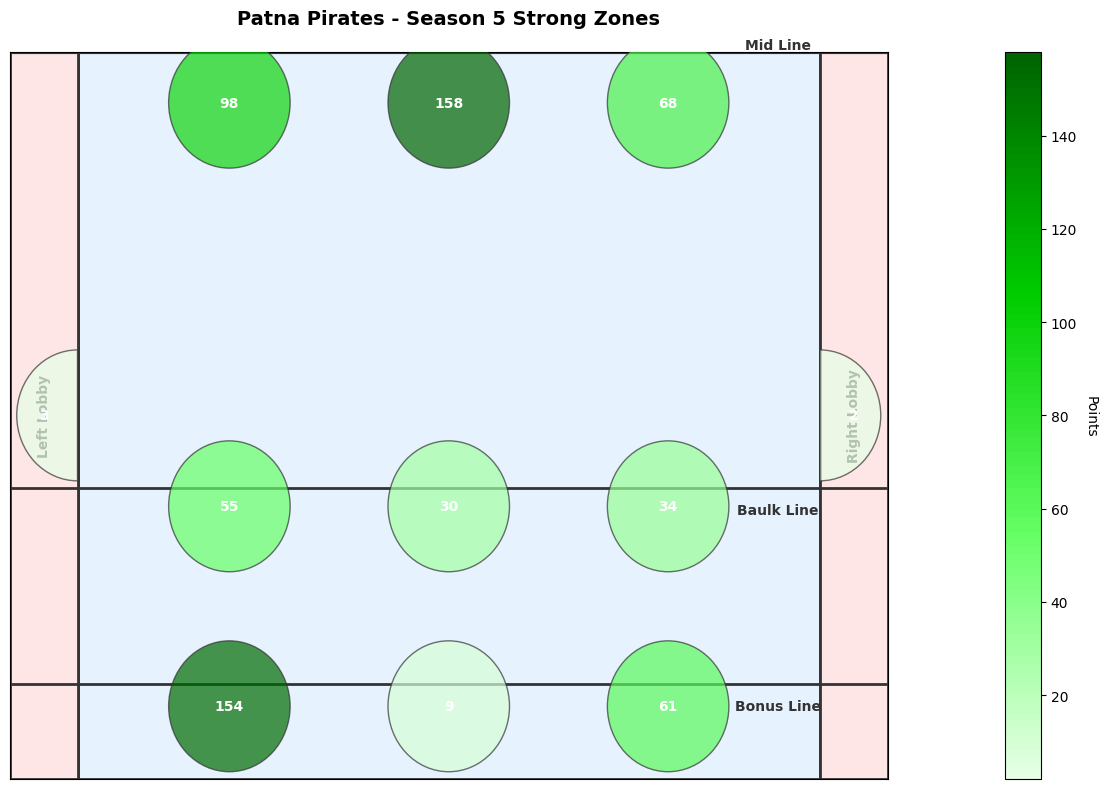

In [62]:
api.plot_team_zones(team_id=6, season=5, zone_type='strong')

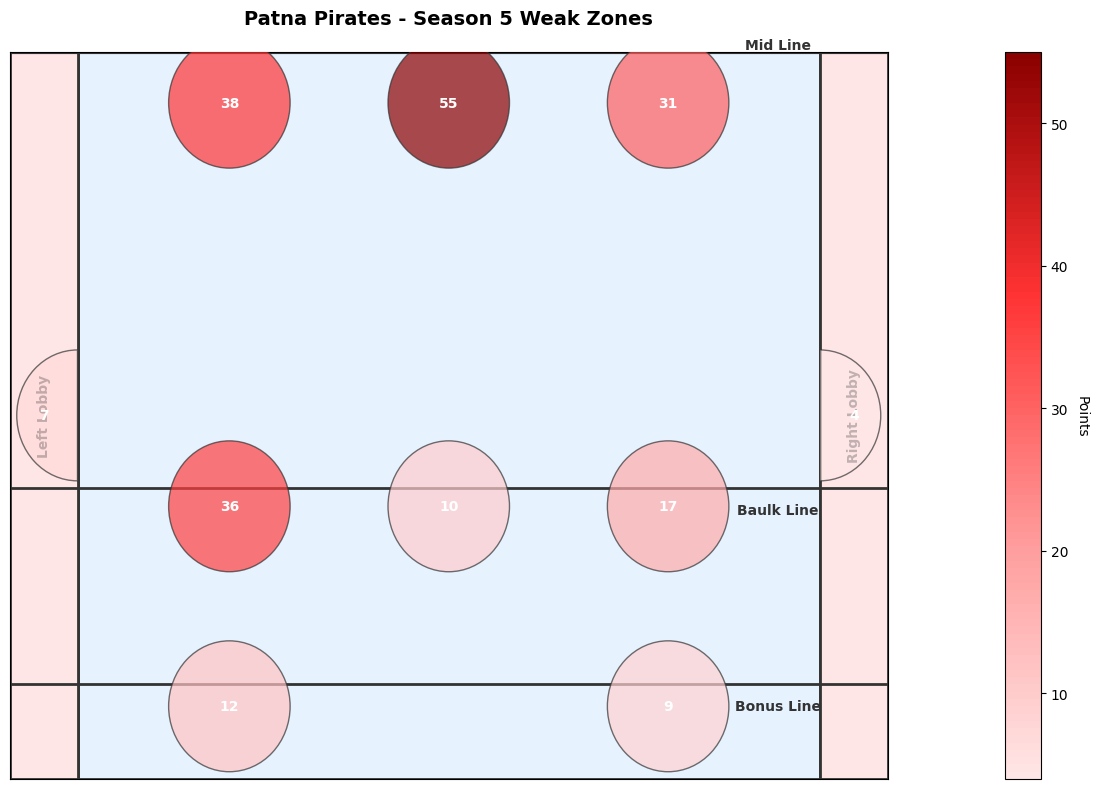

In [63]:
api.plot_team_zones(team_id=6, season=5, zone_type='weak')

With this plot, we know exactly where the points were scored for this season.

But, who scored these points? Let's use `build_team_roster()` to find out the players in season 5 for Patna Pirates

In [76]:
roster = api.build_team_roster(team_id=6, season=5)
roster[['Player ID', 'Name', 'Played Count', 'Total Points', 'Team ID', 'Team Name', 'Total Matches in Season', 'Starter Count',
        'Top Raider Count', 'Top Defender Count','Captain Count', 'Played Count',
       'Green Card Count', 'Yellow Card Count', 'Red Card Count']]


,Player ID,Name,Played Count,Total Points,Team ID,Team Name,Total Matches in Season,Starter Count,Top Raider Count,Top Defender Count,Captain Count,Played Count,Green Card Count,Yellow Card Count,Red Card Count
0,197,Pardeep Narwal,26,369,6,Patna Pirates,26,26,22,0,26,26,0,0,0
1,123,Vishal Mane,26,39,6,Patna Pirates,26,26,0,5,0,26,0,0,0
2,165,Sachin Shingade,26,22,6,Patna Pirates,26,26,0,1,0,26,0,0,0
3,745,Vijay,23,64,6,Patna Pirates,26,15,0,3,0,23,0,0,0
4,388,Monu Goyat,26,202,6,Patna Pirates,26,26,4,0,0,26,0,0,0
5,390,Jawahar Dagar,18,35,6,Patna Pirates,26,15,0,3,0,18,0,0,0
6,579,Jaideep,26,71,6,Patna Pirates,26,26,0,12,0,26,0,0,0
7,342,Zakir Hossain,18,0,6,Patna Pirates,26,0,0,0,0,18,0,0,0
8,299,Sandeep,15,0,6,Patna Pirates,26,0,0,0,0,15,0,0,0
9,728,Manish,26,22,6,Patna Pirates,26,0,0,1,0,26,0,0,0


### Visualizing player contribution to team strength
We can easily see who were the top scorers! But each of these players have different areas of strength.

To analyze their contribution to team strength, we will plot a grid of top scorers' strong zones.

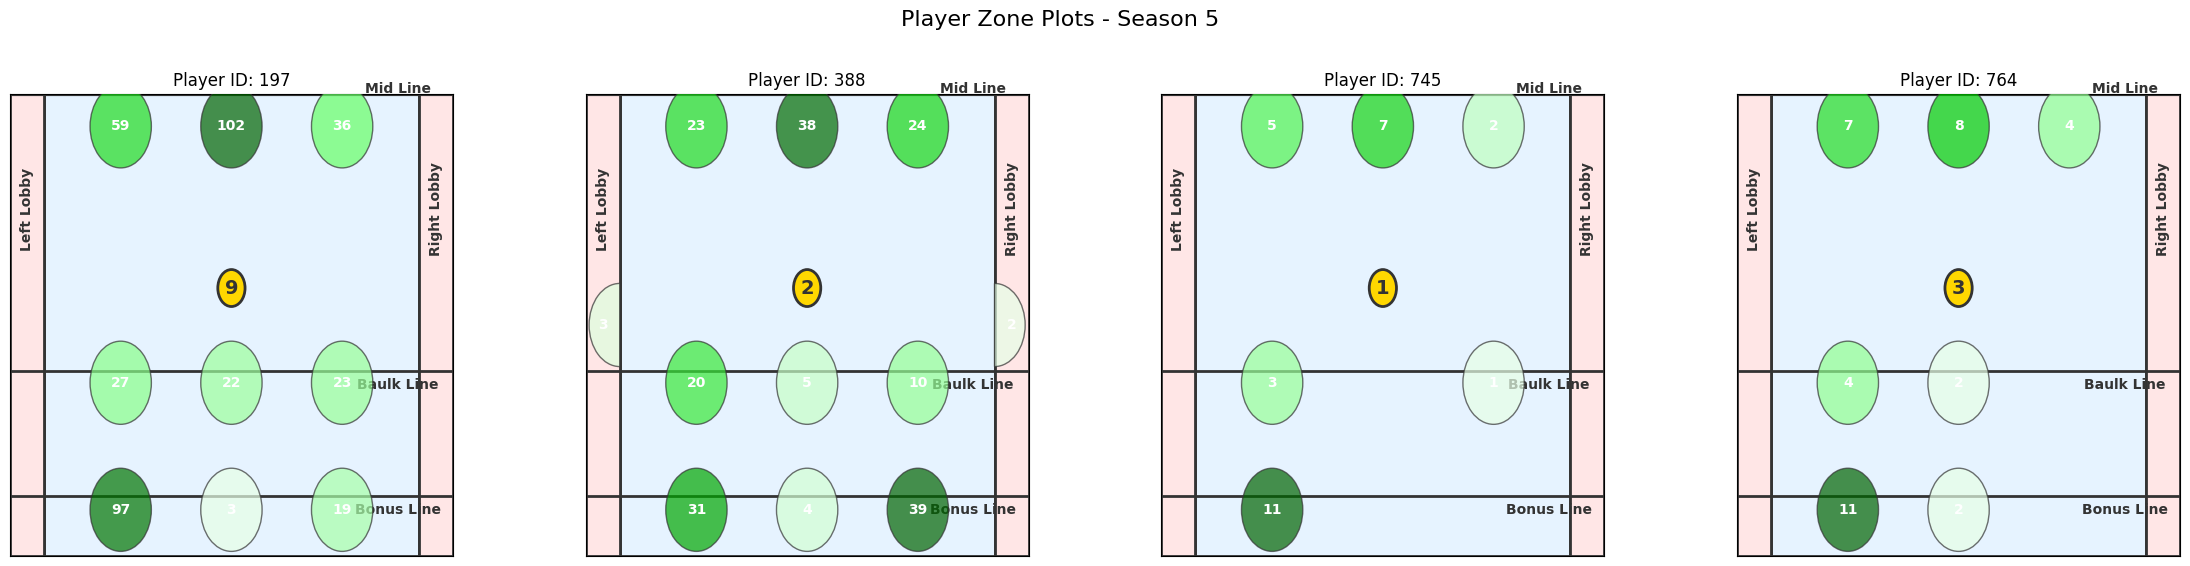

In [71]:
api.plot_player_zones_grid([197,388,745,764],season=5)

## Match Level Analysis

There are two ways of isolating a pivotal match - by a season or for a particular team.

`KabaddiPy` makes it very simple to do both, with `get_season_matches()` and `get_team_matches()`. More functions are provided for play-by-play analysis and retrival of all data related to a match.

In [87]:
#sorting by descending Match_ID to get the latest match in the season
df = api.get_season_matches(season=10)
df.sort_values(by='Match_ID', ascending=False)

,Season,Match_ID,Match_Name,League_Stage,Year,Venue,Match_Outcome,Start_Date,End_Date,Result,Winning Margin,team_score_1,team_score_2,team_name_1,team_id_1,team_name_2,team_id_2
136,10,3165,Final,Final,2023,"Gmc Balayogi Sports Complex, Gachibowli, Hyder...",Puneri Paltan won by 3 Pts,2024-03-01T20:00+05:30,2024-03-01T20:00+05:30,W,3,28,25,Puneri Paltan,7,Haryana Steelers,28
135,10,3164,Semi Final 2,Semi Final,2023,"Gmc Balayogi Sports Complex, Gachibowli, Hyder...",Haryana Steelers won by 4 Pts,2024-02-28T21:00+05:30,2024-02-28T21:00+05:30,W,4,27,31,Jaipur Pink Panthers,3,Haryana Steelers,28
134,10,3163,Semi Final 1,Semi Final,2023,"Gmc Balayogi Sports Complex, Gachibowli, Hyder...",Puneri Paltan won by 16 Pts,2024-02-28T20:00+05:30,2024-02-28T20:00+05:30,W,16,37,21,Puneri Paltan,7,Patna Pirates,6
133,10,3162,Eliminator 2,Playoffs,2023,"Gmc Balayogi Sports Complex, Gachibowli, Hyder...",Haryana Steelers won by 17 Pts,2024-02-26T21:00+05:30,2024-02-26T21:00+05:30,W,17,25,42,Gujarat Giants,31,Haryana Steelers,28
132,10,3161,Eliminator 1,Playoffs,2023,"Gmc Balayogi Sports Complex, Gachibowli, Hyder...",Patna Pirates won by 2 Pts,2024-02-26T20:00+05:30,2024-02-26T20:00+05:30,W,2,35,37,Dabang Delhi K.C.,2,Patna Pirates,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,10,3033,Match 5,League,2023,"Eka Arena By Transstadia, Ahmedabad",Puneri Paltan won by 4 Pts,2023-12-04T20:00+05:30,2023-12-04T20:00+05:30,W,4,37,33,Puneri Paltan,7,Jaipur Pink Panthers,3
3,10,3032,Match 4,League,2023,"Eka Arena By Transstadia, Ahmedabad",Gujarat Giants won by 3 Pts,2023-12-03T21:00+05:30,2023-12-03T21:00+05:30,W,3,34,31,Gujarat Giants,31,Bengaluru Bulls,1
2,10,3031,Match 3,League,2023,"Eka Arena By Transstadia, Ahmedabad",Tamil Thalaivas won by 11 Pts,2023-12-03T20:00+05:30,2023-12-03T20:00+05:30,W,11,42,31,Tamil Thalaivas,29,Dabang Delhi K.C.,2
1,10,3030,Match 2,League,2023,"Eka Arena By Transstadia, Ahmedabad",U Mumba won by 3 Pts,2023-12-02T21:00+05:30,2023-12-02T21:00+05:30,W,3,34,31,U Mumba,5,U.P. Yoddhas,30


Alternatively, matches could be identified for a particular team in focus.

In [83]:
api.get_team_matches(5,5)

,Season,Match_ID,Match_Name,League_Stage,Year,Venue,Match_Outcome,Start_Date,End_Date,Result,Winning Margin,team_score_1,team_score_2,team_name_1,team_id_1,team_name_2,team_id_2
1,5,287,Match 2,League,2017,Gachibowli Indoor Stadium,Puneri Paltan beat U Mumba (33-21),7/28/2017T9:00:00TPM,7/28/2017T9:00:00TPM,W,12,21,33,U Mumba,5,Puneri Paltan,7
4,5,290,Match 5,League,2017,Gachibowli Indoor Stadium,U Mumba beat Haryana Steelers (29-28),7/30/2017T8:00:00TPM,7/30/2017T8:00:00TPM,W,1,29,28,U Mumba,5,Haryana Steelers,28
13,5,299,Match 14,League,2017,Mankapur Indoor Stadium,U Mumba beat Dabang Delhi K.C. (36-22),8/5/2017T8:00:00TPM,8/5/2017T8:00:00TPM,W,14,36,22,U Mumba,5,Dabang Delhi,2
22,5,308,Match 23,League,2017,The Arena By Transstadia,Gujarat Fortunegiants beat U Mumba (39-21),8/11/2017T8:00:00TPM,8/11/2017T8:00:00TPM,W,18,39,21,Gujarat Giants,31,U Mumba,5
33,5,319,Match 34,League,2017,Babu Banarasi Das Indoor Stadium,U Mumba beat U.P. Yoddha (37-34),8/18/2017T8:00:00TPM,8/18/2017T8:00:00TPM,W,3,34,37,U.P. Yoddhas,30,U Mumba,5
35,5,321,Match 36,League,2017,Babu Banarasi Das Indoor Stadium,Telugu Titans beat U Mumba (37-32),8/19/2017T8:00:00TPM,8/19/2017T8:00:00TPM,W,5,37,32,Telugu Titans,8,U Mumba,5
44,5,330,Match 45,League,2017,"Â€˜Dome, Nsci Svp Stadiumâ€™",Jaipur Pink Panthers beat U Mumba (39-36),8/25/2017T8:00:00TPM,8/25/2017T8:00:00TPM,W,3,36,39,U Mumba,5,Jaipur Pink Panthers,3
47,5,333,Match 48,League,2017,"Â€˜Dome, Nsci Svp Stadiumâ€™",Puneri Paltan beat U Mumba (26-24),8/26/2017T9:00:00TPM,8/26/2017T9:00:00TPM,W,2,24,26,U Mumba,5,Puneri Paltan,7
49,5,335,Match 50,League,2017,"Â€˜Dome, Nsci Svp Stadiumâ€™",Dabang Delhi K.C. beat U Mumba (33-32),8/27/2017T9:00:00TPM,8/27/2017T9:00:00TPM,W,1,32,33,U Mumba,5,Dabang Delhi,2
50,5,338,Match 53,League,2017,"Â€˜Dome, Nsci Svp Stadiumâ€™",U Mumba beat Haryana Steelers (38-32),8/30/2017T8:00:00TPM,8/30/2017T8:00:00TPM,W,6,38,32,U Mumba,5,Haryana Steelers,28


## Play by play

`load_pbp()` allows us to directly load the play-by-play events for a particular match given a match id. We will load the pbp events of the Season 10 final (id = 3165)

In [102]:
api.load_pbp(10,3165)

,event_no,event_half,event,event_id,event_text,raider_id,raiding_team_id,defender_id,defending_team_id,raid_points,...,clock,status_id,score,seq_no,defenders,created_date,player_id,substituted_by,team_id,substitute_time
0,1,1,Empty Raid,3,Vinay empty raid,3054.0,28.0,NaN,7.0,0.0,...,20:00,0,"[0, 0]",1,[],2024-03-01T19:59:00,NaN,NaN,NaN,NaN
1,2,1,Empty Raid,3,Aslam Inamdar empty raid,4960.0,7.0,NaN,28.0,0.0,...,19:34,0,"[0, 0]",2,[],2024-03-01T19:59:31,NaN,NaN,NaN,NaN
2,3,1,Unsuccessful Raid,2,Shivam Patare unsuccessful raid,4108.0,28.0,3234.0,7.0,0.0,...,19:05,0,"[1, 0]",3,[3234],2024-03-01T20:00:09,NaN,NaN,NaN,NaN
3,4,1,Empty Raid,3,Mohit Goyat empty raid,4022.0,7.0,NaN,28.0,0.0,...,18:35,0,"[1, 0]",4,[],2024-03-01T20:00:43,NaN,NaN,NaN,NaN
4,5,1,Empty Raid,3,Vinay empty raid,3054.0,28.0,NaN,7.0,0.0,...,18:08,0,"[1, 0]",5,[],2024-03-01T20:01:13,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,94,2,Successful Raid,1,Siddharth Desai raids successfully,2026.0,28.0,NaN,7.0,2.0,...,01:02,0,"[28, 23]",83,"[4960, 4925]",2024-03-01T21:02:55,NaN,NaN,NaN,NaN
94,95,2,Empty Raid,3,Mohit Goyat empty raid,4022.0,7.0,NaN,28.0,0.0,...,00:52,0,"[28, 23]",84,[],2024-03-01T21:03:29,NaN,NaN,NaN,NaN
95,97,2,Successful Raid,1,Siddharth Desai raids successfully,2026.0,28.0,NaN,7.0,1.0,...,00:24,0,"[28, 24]",85,[3234],2024-03-01T21:04:15,NaN,NaN,NaN,NaN
96,98,2,Yellow Card,10,None,NaN,NaN,NaN,NaN,NaN,...,00:07,0,None,0,NaN,2024-03-01T21:04:15,3234.0,NaN,NaN,NaN


### Retrieval of match information

If an analyst wanted detailed info for a game, this is obtained by `load_match_details()` This information is returned in 6 dataframes including :

- Match Detail: Summary of match and metadata 

- events_df: All play-by-play events 

- zones_df: Information about different zones on the court. 

- team1_df and team2_df: Detailed information about both teams.

- breakdown_df: Team top level comparison for the match

In [90]:
match_details, events, zones, team1, team2, breakdown_comparison = api.load_match_details(10,3165)

In [98]:
match_details.T

,0
match_id,3165
match_number,Final
clock_minutes,40
clock_seconds,8
date,3/1/2024
start_time,20:00
matchtime_iso,2024-03-01T14:30:00Z
gmtoffset,+05:30
result_value,Puneri Paltan Beat Haryana Steelers (28-25 )
result_winning_method,W


We will point the point progression of the match

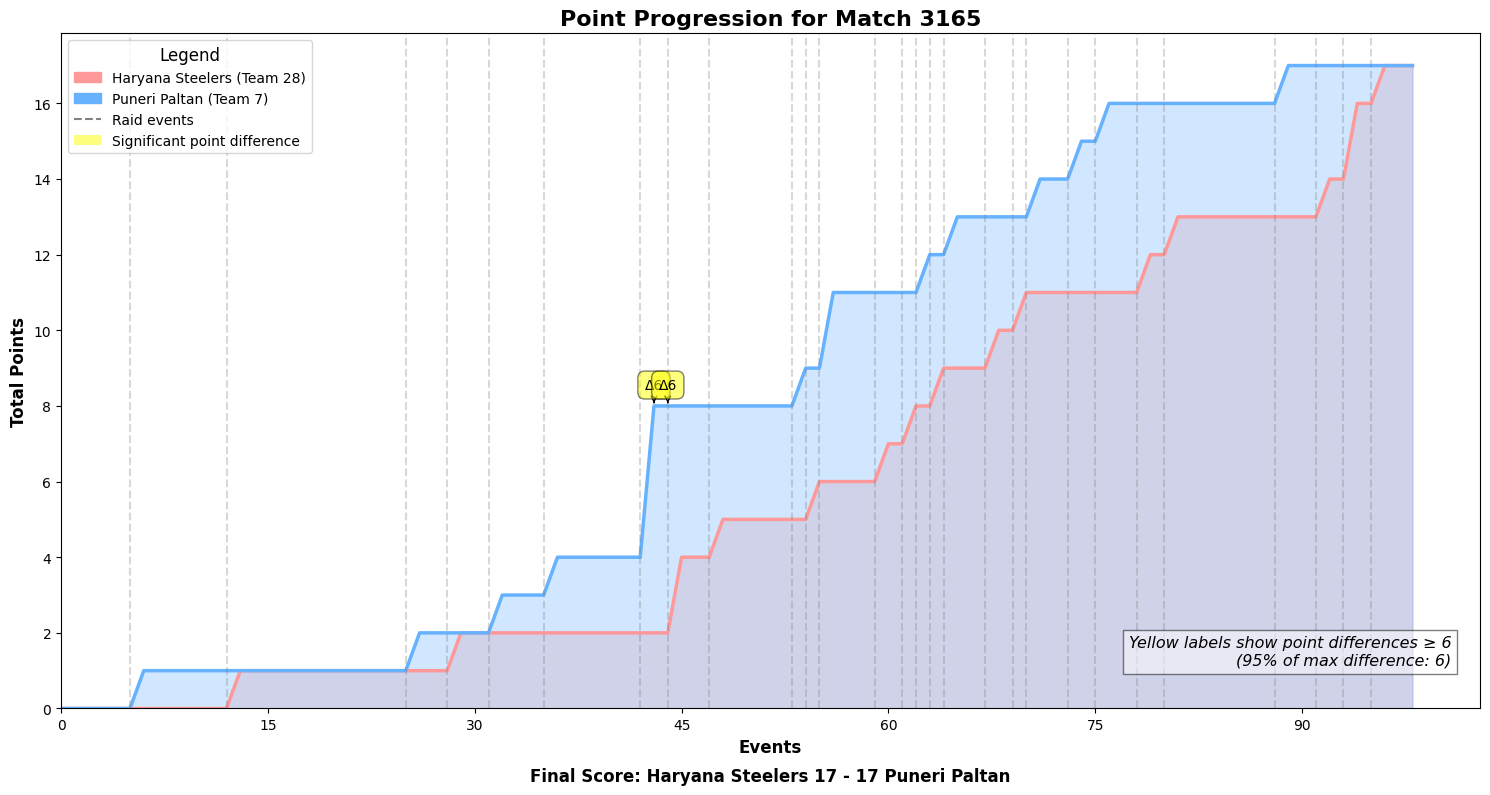

In [101]:
api.plot_point_progression(10,3165)

This was a very close match! Play-by-play events of this match can help identify the crucial junctures in this match.

In [92]:
events #play-by-play

,event_no,event_half,event,event_id,event_text,raider_id,raiding_team_id,defender_id,defending_team_id,raid_points,...,clock,status_id,score,seq_no,defenders,created_date,player_id,substituted_by,team_id,substitute_time
0,1,1,Empty Raid,3,Vinay empty raid,3054.0,28.0,NaN,7.0,0.0,...,20:00,0,"[0, 0]",1,[],2024-03-01T19:59:00,NaN,NaN,NaN,NaN
1,2,1,Empty Raid,3,Aslam Inamdar empty raid,4960.0,7.0,NaN,28.0,0.0,...,19:34,0,"[0, 0]",2,[],2024-03-01T19:59:31,NaN,NaN,NaN,NaN
2,3,1,Unsuccessful Raid,2,Shivam Patare unsuccessful raid,4108.0,28.0,3234.0,7.0,0.0,...,19:05,0,"[1, 0]",3,[3234],2024-03-01T20:00:09,NaN,NaN,NaN,NaN
3,4,1,Empty Raid,3,Mohit Goyat empty raid,4022.0,7.0,NaN,28.0,0.0,...,18:35,0,"[1, 0]",4,[],2024-03-01T20:00:43,NaN,NaN,NaN,NaN
4,5,1,Empty Raid,3,Vinay empty raid,3054.0,28.0,NaN,7.0,0.0,...,18:08,0,"[1, 0]",5,[],2024-03-01T20:01:13,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,94,2,Successful Raid,1,Siddharth Desai raids successfully,2026.0,28.0,NaN,7.0,2.0,...,01:02,0,"[28, 23]",83,"[4960, 4925]",2024-03-01T21:02:55,NaN,NaN,NaN,NaN
94,95,2,Empty Raid,3,Mohit Goyat empty raid,4022.0,7.0,NaN,28.0,0.0,...,00:52,0,"[28, 23]",84,[],2024-03-01T21:03:29,NaN,NaN,NaN,NaN
95,97,2,Successful Raid,1,Siddharth Desai raids successfully,2026.0,28.0,NaN,7.0,1.0,...,00:24,0,"[28, 24]",85,[3234],2024-03-01T21:04:15,NaN,NaN,NaN,NaN
96,98,2,Yellow Card,10,None,NaN,NaN,NaN,NaN,NaN,...,00:07,0,None,0,NaN,2024-03-01T21:04:15,3234.0,NaN,NaN,NaN


In [94]:
zones # the zones of a Kabaddi mat for reference.

,id,name
0,1,Left Lobby
1,2,Right Lobby
2,3,Midline Left
3,4,Midline Centre
4,5,Midline Right
5,6,Baulk Left
6,7,Baulk Centre
7,8,Baulk Right
8,9,Bonus Left
9,10,Bonus Centre


In [99]:
breakdown_comparison

,team_id,team_name,raids_total,raids_successful,raids_unsuccessful,raids_empty,tackles_total,tackles_successful,tackles_unsuccessful,points_total,points_raid,points_tackle,points_all_out,points_extras,raid_success_rate,tackle_success_rate,longest_streak,streak_percent
0,7,Puneri Paltan,43,12,6,25,20,9,11,28,17,9,2,0,27.91,45.00,10,66.666667
1,28,Haryana Steelers,43,15,9,19,21,5,16,25,17,5,0,3,34.88,23.81,5,33.333333


### Visualizing the team's performance againt each other

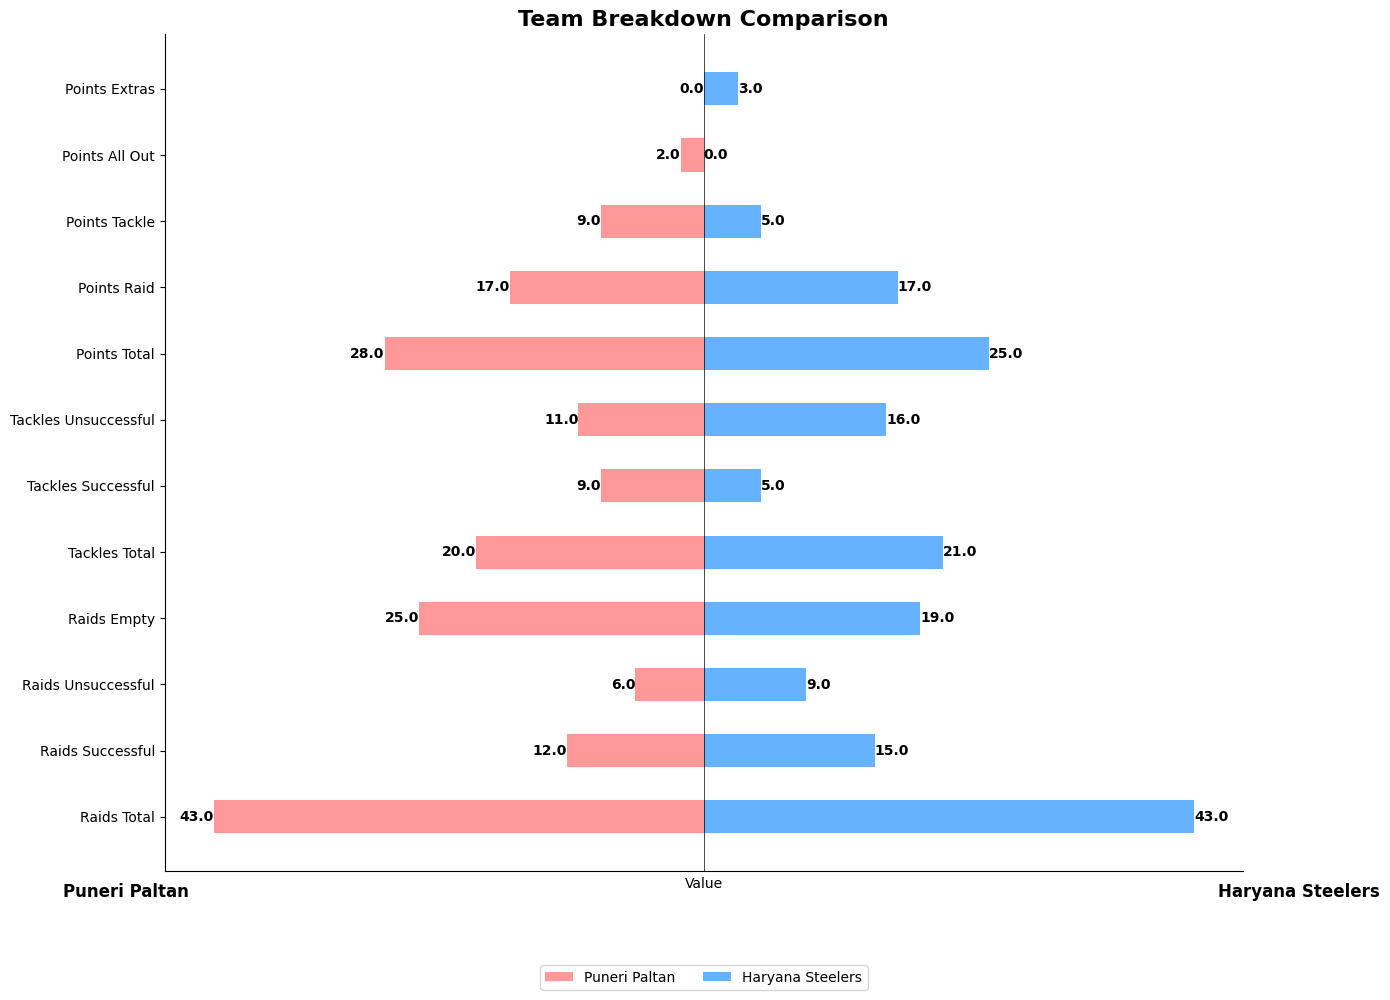

In [100]:
def plot_team_breakdown(breakdown_df):
    breakdown_df = breakdown_df.T
    # Prepare the data
    metrics = ['raids_total', 'raids_successful', 'raids_unsuccessful', 'raids_empty',
            'tackles_total', 'tackles_successful', 'tackles_unsuccessful',
            'points_total', 'points_raid', 'points_tackle', 'points_all_out', 'points_extras']

    team1_name = breakdown_df.loc['team_name', 0]
    team2_name = breakdown_df.loc['team_name', 1]

    team1_values = breakdown_df.loc[metrics, 0].astype(float)
    team2_values = breakdown_df.loc[metrics, 1].astype(float)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(14, 10))
    y_pos = np.arange(len(metrics))

    # Create the horizontal bars on opposite sides
    ax.barh(y_pos, -team1_values, height=0.5, align='center', label=team1_name, color='#FF9999')
    ax.barh(y_pos, team2_values, height=0.5, align='center', label=team2_name, color='#66B2FF')

    # Customize the plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels([metric.replace('_', ' ').title() for metric in metrics])
    ax.set_xlabel('Value')
    ax.set_title('Team Breakdown Comparison', fontsize=16, fontweight='bold')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2)

    # Add value labels on the bars
    for i, v in enumerate(team1_values):
        ax.text(-v, i, str(v), va='center', ha='right', fontweight='bold')
    for i, v in enumerate(team2_values):
        ax.text(v, i, str(v), va='center', ha='left', fontweight='bold')

    # Add a light grid
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set the x-axis limits to be symmetric
    max_value = max(team1_values.max(), team2_values.max())
    ax.set_xlim(-max_value * 1.1, max_value * 1.1)

    # Add team names as x-axis labels
    ax.text(-max_value * 1.05, -1, team1_name, ha='right', va='top', fontsize=12, fontweight='bold')
    ax.text(max_value * 1.05, -1, team2_name, ha='left', va='top', fontsize=12, fontweight='bold')

    # Remove x-axis ticks
    ax.set_xticks([])

    # Add a vertical line at x=0
    ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


# Call the function to plot the breakdown data
plot_team_breakdown(breakdown_comparison)

## Player Level Analysis 

`KabaddiPy` allows for studying granular level details of a player with `get_player_info()` and `get_matchwise_player_info()` alongside visual analysis of their strenghts and weakness areas

In [121]:
stats_rank, stats_value, stats_per_match, rvd = api.get_player_info(143,5)

In [122]:
stats_rank

,266
season,5
player_id,143
player_name,Maninder Singh
player_matches_played,21
player_position_id,8
player_position_name,Raider
team_id,4
team_full_name,Bengal Warriors
player-super-tackles_rank,NaN
player-raid-points_rank,5.0


In [123]:
stats_per_match

,266
season,5
player_id,143
player_name,Maninder Singh
player_matches_played,21
player_position_id,8
player_position_name,Raider
team_id,4
team_full_name,Bengal Warriors
player-super-tackles_points_per_match,NaN
player-raid-points_points_per_match,9.05


## Plotting the player weak zones

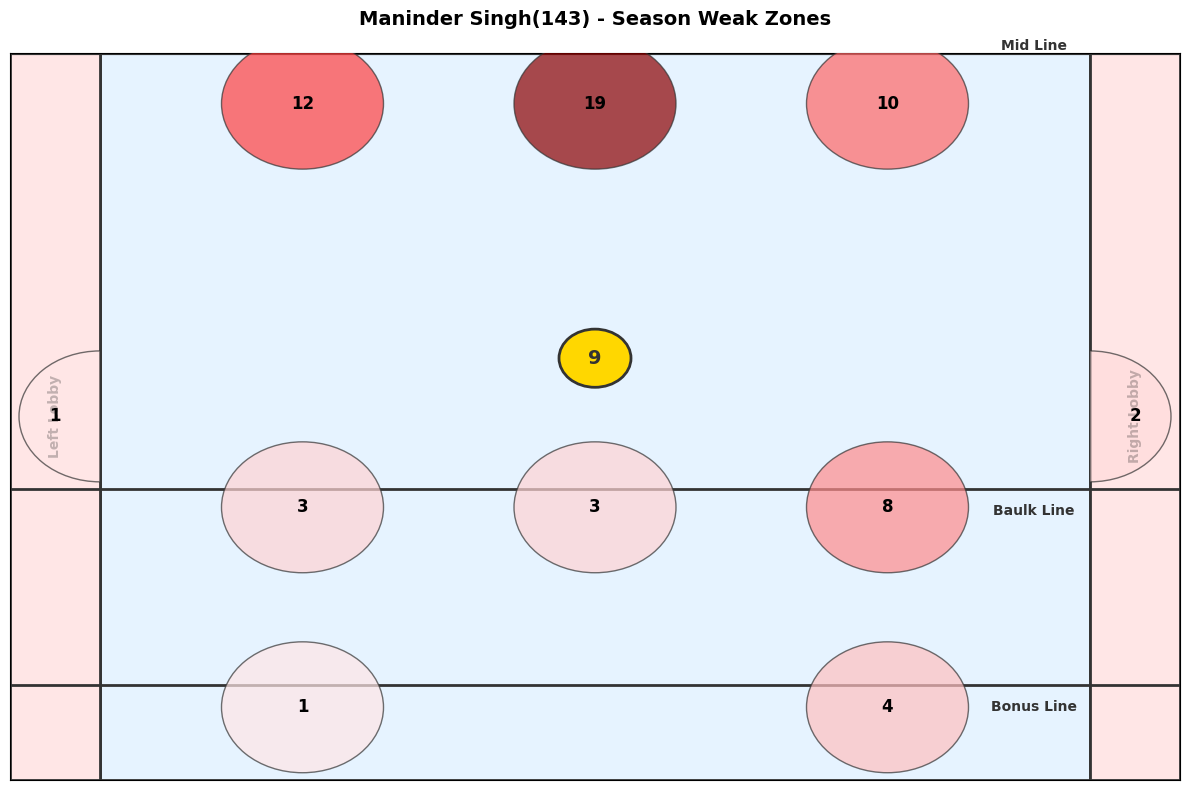

In [128]:
api.plot_player_zones_improved(143,season=5,zone_type='weak')